<a href="https://colab.research.google.com/github/LuisMendezTEC/Proyecto-Programado-1/blob/main/Jan_Luis_Proyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica | TEC
# Carrera de Ingeniería en Computación 
# I Semestre de 2023
# Proyecto Programado (Fase I – Entrevistador asistido por IA) 
# Dr. Abel Méndez Porras
# amendez@itcr.ac.cr
# Porcentaje: 20%

# Entrevistador asistido por IA



El reconocimiento facial y la detección de emociones son tecnologías que se han vuelto cada vez más populares en los últimos años. Estas tecnologías utilizan algoritmos de inteligencia artificial para analizar imágenes y detectar patrones faciales que permiten identificar a las personas y sus emociones.
En cuanto a las oportunidades, el reconocimiento facial puede tener aplicaciones en la seguridad, el marketing y la atención al cliente. Por ejemplo, en la seguridad se pueden utilizar sistemas de reconocimiento facial para identificar a personas en lugares públicos o para controlar el acceso a edificios y sistemas de seguridad. En el marketing, se pueden utilizar para personalizar la publicidad en función de la edad, el género y otros datos demográficos. Y en la atención al cliente, se pueden utilizar para detectar la satisfacción del cliente en tiempo real y responder adecuadamente.

En esta primera etapa del proyecto del curso de Taller de Programación estaremos utilizando los resultados de consultas a modelos de Deep Learning para aplicar los conocimientos adquiridos en clase. 

## Objetivo
Desarrollar una aplicación de complejidad baja que permita poner en práctica los conocimientos adquiridos en los cursos de Introducción a la Programación y Taller de Programación.
## Objetivos Específicos
*   Identificar los requerimientos para resolver un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.
*   Diseñar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.
*.  Desarrollar una aplicación para un problema específico desde la perspectiva de resolución de problemas, técnicas con listas y diccionarios.

## Configuración previa 

### Cargar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Leer cámara
Tomado de https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb



### Importar dependencies

In [ ]:
# import dependencies
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from numpy import asarray
import io
import glob
import cv2
import os
import numpy as np
import PIL
import io
import html
import time
import pickle

### Convertir el objeto JavaScript un objeto OpenCV image

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

### Crear nuestro live video stream

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Iniciar streaming video

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import model_from_json

### Cargar modelos de Deep Learning entrenados

*   Para detectar los rostros se utiliza el modelo de Face Haar Cascade.
*   Para detectar las emociones se utiliza el modelo de VGG.
*   También se utiliza un algoritmo adicional para pasar la información del algortimo de VGG a un formato JSON.

Estos modelos y algoritmos están disponibles en el siguiente enlace [Descargar modelos y algoritmos](https://drive.google.com/drive/folders/1KctA_s25bqqMOUlQuy0lwTm0HkBGVycF?usp=sharing). Usted los debe colocar en su Google Drive y modificar la ruta de acceso. 



In [ ]:
#Cargar modelos de Deep Learning entrenados
face_haar_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Deep Learning/haarcascade_frontalface_alt.xml') 
model = model_from_json(open("/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Deep Learning/model.json", "r").read()) 
model.load_weights('/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Deep Learning/model.h5')

Crear interfaz
https://www.youtube.com/watch?v=oIVmV41uyK8

###Sacar los fotogramas a cada video

In [ ]:
import cv2
 
# Opens the Video file
#video= cv2.VideoCapture('https://sample-videos.com/video123/mp4/720/big_buck_bunny_720p_1mb.mp4')
video= cv2.VideoCapture('/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/Jan.mp4')
i=0
j = 150
while(video.isOpened()):  #abre el video
    ret, frame = video.read() #obtiene cada fotograma 

    if ret == False:  #si no obtiene ningún fotograma se termina el ciclo
        break

    if i == j:     #obtenemos el fotograma cada 20
      cv2.imwrite('/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/Pruebitas2/'+ 'Jan'+str(i)+'.jpg',frame) #se guarda el fotograma con el nombre más el número del contador i
      j +=150
    i+=1

video.release()


#Entrevista personal

## Recolectar información personal


Información requerida al entrevistar una persona (Toda esta información debe ser almacenada en un diccionario. Cada diccionario de cada entrevista debe ser colocado en una lista. Se maneja una lista principal donde se tiene todas las entrevistas de las personas).
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección
*   Estado civil
*   Cantidad de hijos indicando el género, la fecha de nacimiento(un diccionario) 
*   Entrevistas (cada persona puede ser entrevistada cero o más veces). Las entrevistas se realizan en tiempo real utilizando una camára integrada a la computadora o externa (el profesor facilita el código para activar la camára, capturar el video y capturar los frames cada cierto tiempo). Se debe crear una lista con sublistas donde cada sublista tiene las imagenes capturas y las emociones reportadas durante la entrevista. Además, debe guardar coordenadas donde se encuentra el rostro en la imagen. Para cada entrevista, el entrevistado debe contar historias cortas sobre los siguientes 4 tópicos:


  >*   Una experiencia de sorpresa o asombro que ha tenido que vivir.
  >*   Una experiencia de tristeza que ha tenido que vivir.
  >*   Una experiencia de enojo o frustración que ha tenido que vivir.
  >*   Una experiencia de felicidad que ha tenido que vivir.




In [ ]:
lista_principal=[]
entrevistas={"entrevista1":{"Genero":"masculino","Identificación":2023141516, "Nombre":"Samuel Mendez", "Fecha de nacimiento":"12/02/2004", "Edad":[19],
             "Nacionalidad":"Costarricense" ,"Números de teléfono":{21212121,20202020}, "emails":["cluisandres486@gmail.com, lemendez@estudiantec.cr"], 
             "dirección": "1 Km al norte de la Escuela Buenos Aires de Venecia", "Estado civil":"Soltereo","Hijos":{"Cantidad": [1],"Genero":["masculino"],
              "Fecha de nacimiento":["04/1/2012", "02/08/2017"]}},
             "entrevista2": {"Genero":"masculino","Identificación":2023074542, "Nombre":"Maikol Flores", "Fecha de nacimiento":"15/11/2004", "Edad":[18],
              "Nacionalidad":"Costarricense" , "Números de teléfono":{60252260}, "emails":["janpaulo1115@gmail.com, janmolina@estudiantec.cr"],
             "dirección": "100mts al norte y 100mts al este de la Escuela Viento Fresco", "Estado civil": "Soltero", 
             "Hijos":{"Cantidad":[2],"Genero":["femenino", "masculino"],"Fecha de nacimiento":["01/11/2011", "19/09/2018"], "Coordenadas": ""}}}
lista_principal.append(entrevistas)
print(lista_principal)

[{'entrevista1': {'Genero': 'masculino', 'Identificación': 2023141516, 'Nombre': 'Samuel Mendez', 'Fecha de nacimiento': '12/02/2004', 'Edad': [19], 'Nacionalidad': 'Costarricense', 'Números de teléfono': {21212121, 20202020}, 'emails': ['cluisandres486@gmail.com, lemendez@estudiantec.cr'], 'dirección': '1 Km al norte de la Escuela Buenos Aires de Venecia', 'Estado civil': 'Soltereo', 'Hijos': {'Cantidad': [1], 'Genero': ['masculino'], 'Fecha de nacimiento': ['04/1/2012', '02/08/2017']}}, 'entrevista2': {'Genero': 'masculino', 'Identificación': 2023074542, 'Nombre': 'Maikol Flores', 'Fecha de nacimiento': '15/11/2004', 'Edad': [18], 'Nacionalidad': 'Costarricense', 'Números de teléfono': {60252260}, 'emails': ['janpaulo1115@gmail.com, janmolina@estudiantec.cr'], 'dirección': '100mts al norte y 100mts al este de la Escuela Viento Fresco', 'Estado civil': 'Soltero', 'Hijos': {'Cantidad': [2], 'Genero': ['femenino', 'masculino'], 'Fecha de nacimiento': ['01/11/2011', '19/09/2018'], 'Coord

###Coordenadas del rostro


#Perfiles del Entrevistador Personal

El entrevistador personal es una herramienta para recolectar información de personas que están aplicando a un puesto. En la aplicación existen tres perfiles el entrevistador, el entrevistado y el evaluador. La información de estos perfiles debe ser almacenada en clases y usando herencia. Debe existir una clase "padre" que tiene propiedades y métodos que comparten todos los perfiles. Para cada perfil debe existir una clase subordinada que hereda las propiedades de la clase "padre", además, tiene sus propias propiedades y métodos.

## Recolectar información del entrevistador


El entrevistador es la persona encargada de realizar las entrevistas. 

Información requerida del entrevistador (Toda la información requerida debe ser almacenada en la clase Entrevistador. Cada vez que se registra un entrevistador se debe crear una instancia de la clase Entrevistador para guardar toda la información del entrevistador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al entrevistador.
Cada vez que se crea una instancia de Entrevistador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Entrevistador.

In [ ]:
class Entrevistador:
    def __init__(self, identificacion, nombre, fecha_nacimiento, nacionalidad, telefonos, emails, direccion, experiencia, idiomas, titulacion):
        self.identificacion = identificacion
        self.nombre = nombre
        self.fecha_nacimiento = fecha_nacimiento
        self.nacionalidad = nacionalidad
        self.telefonos = telefonos
        self.emails = emails
        self.direccion = direccion
        self.experiencia = experiencia
        self.idiomas = idiomas
        self.titulacion = titulacion

    def guardar_en_archivo(self, archivo):
        with open(archivo, 'wb') as f:
            pickle.dump(self, f)

# Crear instancia de Entrevistador y llenar los valores
identificacion = input("Ingrese la identificación del entrevistador: ")
nombre = input("Ingrese el nombre del entrevistador: ")
fecha_nacimiento = input("Ingrese la fecha de nacimiento del entrevistador: ")
nacionalidad = input("Ingrese la nacionalidad del entrevistador: ")
telefonos = {
    'telefono': input("Ingrese el número de teléfono del entrevistador: "),
    'celular': input("Ingrese el número de celular del entrevistador: ")
}
emails = [input("Ingrese el email del entrevistador: ")]
direccion = input("Ingrese la dirección del entrevistador: ")
experiencia = input("Ingrese la experiencia del entrevistador: ")
idiomas = input("Ingrese los idiomas que habla el entrevistador: ")
titulacion = input("Ingrese la titulación del entrevistador: ")

entrevistador = Entrevistador(identificacion, nombre, fecha_nacimiento, nacionalidad, telefonos, emails, direccion, experiencia, idiomas, titulacion)

# Guardar la instancia en un archivo en Google Drive
archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Entrevistadores/' + identificacion + '.bin'
entrevistador.guardar_en_archivo(archivo)
print("El entrevistador ha sido guardado exitosamente en el archivo:", archivo)


Ingrese la identificación del entrevistador: dcsc
Ingrese el nombre del entrevistador: cscs
Ingrese la fecha de nacimiento del entrevistador: csdcs
Ingrese la nacionalidad del entrevistador: csdcs
Ingrese el número de teléfono del entrevistador: csdcs
Ingrese el número de celular del entrevistador: cscds
Ingrese el email del entrevistador: scds
Ingrese la dirección del entrevistador: csdcs
Ingrese la experiencia del entrevistador: scsd
Ingrese los idiomas que habla el entrevistador: csdcs
Ingrese la titulación del entrevistador: csdcs
El entrevistador ha sido guardado exitosamente en el archivo: /content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Entrevistadores/dcsc.bin


In [ ]:
def cargar_entrevistadores(id):
    entrevistadores = []
    entrevistadorbin = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Entrevistadores/' + id + '.bin'
    with open(entrevistadorbin, 'rb') as f:
        while True:
            try:
                entrevistador = pickle.load(f)
                entrevistadores.append(entrevistador)
            except EOFError:
                break
    
    # Imprimir los datos de cada entrevistador
    for entrevistador in entrevistadores:
        print("Identificación:", entrevistador.identificacion)
        print("Nombre:", entrevistador.nombre)
        print("Fecha de nacimiento:", entrevistador.fecha_nacimiento)
        print("Nacionalidad:", entrevistador.nacionalidad)
        print("Teléfonos:", entrevistador.telefonos)
        print("Emails:", entrevistador.emails)
        print("Dirección:", entrevistador.direccion)
        print("Experiencia:", entrevistador.experiencia)
        print("Idiomas:", entrevistador.idiomas)
        print("Titulación:", entrevistador.titulacion)
        print("------------------------")

# Ejemplo de uso de la función
#id = input("Ingrese el nombre del archivo binario (.bin) que desea cargar: ")
#cargar_entrevistadores(id)

Ingrese el nombre del archivo binario (.bin) que desea cargar: dcsc
Identificación: dcsc
Nombre: cscs
Fecha de nacimiento: csdcs
Nacionalidad: csdcs
Teléfonos: {'telefono': 'csdcs', 'celular': 'cscds'}
Emails: ['scds']
Dirección: csdcs
Experiencia: scsd
Idiomas: csdcs
Titulación: csdcs
------------------------


## Recolectar información del evaluador

El evaluador en la persona encargada de revisar la información obtenida de cada entrevista. 

Información requerida del evaluador (Toda la información requerida debe ser almacenada en la clase Evaluador. Cada vez que se registra un evaluador se debe crear una instancia de la clase Evaluador para guardar toda la información del evaluador). 
*   Identificación  
*   Nombre 
*   Fecha de nacimiento
*   Nacionalidad
*   Números de teléfono y celular (un diccionario)
*   Emails (una lista con uno o varios emails)
*   Dirección

Usted debe incluir al menos tres propiedades únicas al evaluador.
Cada vez que se crea una instancia de Evaluador, la instancia debe ser almacenada en un archivo binario llamado Archivo_Evaluador.

In [ ]:
class Evaluador:
    def __init__(self, identificacion, nombre, fecha_nacimiento, nacionalidad, telefonos, emails, direccion, reputaciondel1a10, riguroso, conocermercado):
        self.identificacion = identificacion
        self.nombre = nombre
        self.fecha_nacimiento = fecha_nacimiento
        self.nacionalidad = nacionalidad
        self.telefonos = telefonos
        self.emails = emails
        self.direccion = direccion
        self.reputaciondel1a10 = reputaciondel1a10
        self.riguroso = riguroso
        self.conocermercado = conocermercado

    def guardar_en_archivo(self, archivo):
        with open(archivo, 'wb') as f:
            pickle.dump(self, f)

# Crear instancia de Evaluador y llenar los valores
identificacion = input("Ingrese la identificación del evaluador: ")
nombre = input("Ingrese el nombre del evaluador: ")
fecha_nacimiento = input("Ingrese la fecha de nacimiento del evaluador: ")
nacionalidad = input("Ingrese la nacionalidad del evaluador: ")
telefonos = {
    'telefono': input("Ingrese el número de teléfono del evaluador: "),
    'celular': input("Ingrese el número de celular del evaluador: ")
}
emails = [input("Ingrese el email del evaluador: ")]
direccion = input("Ingrese la dirección del evaluador: ")
reputaciondel1a10 = input("Ingrese el nivel de la reputación del entrevistador en una escala del 1 al 10: ")
riguroso = input("Ingrese el nivel de la rigurosidad en una escala del 1 al 10 : ")
conocermercado = input("Ingrese el nivel del conocimiento del mercado en una escala del 1 al 10: ")

evaluador = Evaluador(identificacion, nombre, fecha_nacimiento, nacionalidad, telefonos, emails, direccion, reputaciondel1a10, riguroso, conocermercado)

# Guardar la instancia en un archivo binario
archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Evaluadores/ ' + identificacion + '.bin'
evaluador.guardar_en_archivo(archivo)
print("El evaluador ha sido guardado exitosamente en el archivo:", archivo)


Ingrese la identificación del evaluador: foris
Ingrese el nombre del evaluador: d
Ingrese la fecha de nacimiento del evaluador: s
Ingrese la nacionalidad del evaluador: a
Ingrese el número de teléfono del evaluador: s
Ingrese el número de celular del evaluador: f
Ingrese el email del evaluador: s
Ingrese la dirección del evaluador: f
Ingrese el nivel de la reputación del entrevistador en una escala del 1 al 10: s
Ingrese el nivel de la rigurosidad en una escala del 1 al 10 : s
Ingrese el nivel del conocimiento del mercado en una escala del 1 al 10: s
El evaluador ha sido guardado exitosamente en el archivo: /content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Evaluadores/ foris.bin


In [ ]:
def cargar_evaluadores(id):
    evaluadores = []
    evaluadorbin = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Evaluadores/ ' + id + '.bin'
    with open(evaluadorbin, 'rb') as f:
        while True:
            try:
                evaluador = pickle.load(f)
                evaluadores.append(evaluador)
            except EOFError:
                break
    
    # Imprimir los datos de cada entrevistador
    for evaluador in evaluadores:
        print("Identificación:", evaluador.identificacion)
        print("Nombre:", evaluador.nombre)
        print("Fecha de nacimiento:", evaluador.fecha_nacimiento)
        print("Nacionalidad:", evaluador.nacionalidad)
        print("Teléfonos:", evaluador.telefonos)
        print("Emails:", evaluador.emails)
        print("Dirección:", evaluador.direccion)
        print("Reputacion:", evaluador.reputaciondel1a10)
        print("Rigurosidad:", evaluador.riguroso)
        print("Conocimiento del mercado:", evaluador.conocermercado)
        print("------------------------")

# Ejemplo de uso de la función
id = input("Ingrese el nombre del archivo binario (.bin) que desea cargar: ")
cargar_evaluadores(id)


Ingrese el nombre del archivo binario (.bin) que desea cargar: foris
Identificación: foris
Nombre: d
Fecha de nacimiento: s
Nacionalidad: a
Teléfonos: {'telefono': 's', 'celular': 'f'}
Emails: ['s']
Dirección: f
Reputacion: s
Rigurosidad: s
Conocimiento del mercado: s
------------------------


## Recolectar información emociones
Este código se encarga de ejecutar la captura de video de la cámara, detectar los rostros en las imágenes y reconocer las emociones presentes en los rostros. Cuando se hace la entrevista es en este código donde usted de obtener la información para crear las listas con la información solicitada.

Digite la cédula de la persona a entrevistar: 2023074542


<IPython.core.display.Javascript object>

Ubicación del rostro: [[293 178 187 187]]
1/1 [==============================] - 0s 306ms/step
Predicciones:  [[5.3371268e-04 9.7133425e-06 5.3308188e-04 9.8821974e-01 1.5938709e-03
  2.2682354e-04 8.8831307e-03]]
3 [5.3371268e-04 9.7133425e-06 5.3308188e-04 9.8821974e-01 1.5938709e-03
 2.2682354e-04 8.8831307e-03]
Predicciones: {'angry': 0.0005337127, 'disgust': 9.7133425e-06, 'fear': 0.0005330819, 'happiness': 0.98821974, 'sadness': 0.0015938709, 'surprise': 0.00022682354, 'neutral': 0.008883131}
happyness


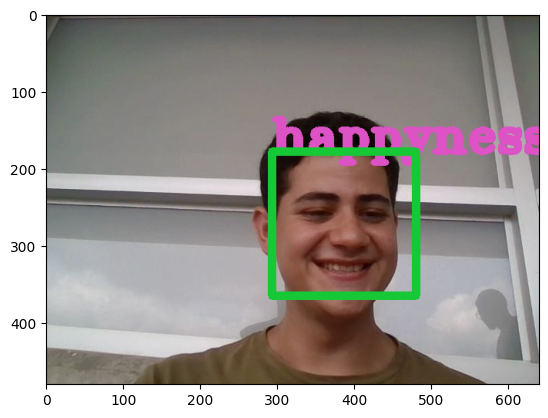

Ubicación del rostro: [[301 189 190 190]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.11275947 0.00903617 0.11731043 0.23512903 0.35444146 0.009248
  0.1620754 ]]
4 [0.11275947 0.00903617 0.11731043 0.23512903 0.35444146 0.009248
 0.1620754 ]
Predicciones: {'angry': 0.11275947, 'disgust': 0.009036167, 'fear': 0.11731043, 'happiness': 0.23512903, 'sadness': 0.35444146, 'surprise': 0.009248003, 'neutral': 0.1620754}
sadness


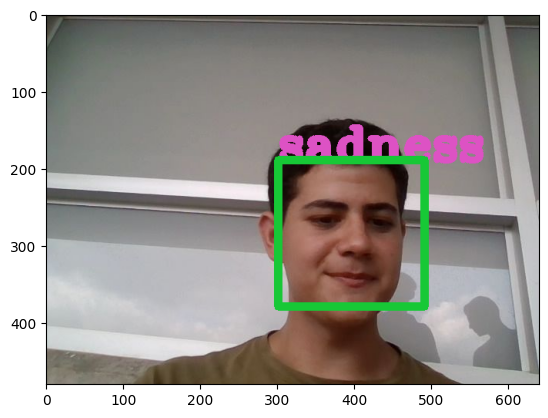

Ubicación del rostro: [[295 196 180 180]]
1/1 [==============================] - 0s 70ms/step
Predicciones:  [[0.1660691  0.01386137 0.16131665 0.13112362 0.343711   0.01595765
  0.16796066]]
4 [0.1660691  0.01386137 0.16131665 0.13112362 0.343711   0.01595765
 0.16796066]
Predicciones: {'angry': 0.1660691, 'disgust': 0.013861374, 'fear': 0.16131665, 'happiness': 0.13112362, 'sadness': 0.343711, 'surprise': 0.015957654, 'neutral': 0.16796066}
sadness


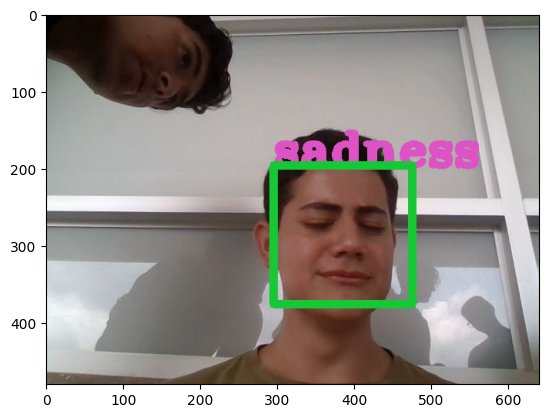

Ubicación del rostro: [[336 199 187 187]]
1/1 [==============================] - 0s 60ms/step
Predicciones:  [[0.04913695 0.00548702 0.04184452 0.5731804  0.23000884 0.00329619
  0.09704603]]
3 [0.04913695 0.00548702 0.04184452 0.5731804  0.23000884 0.00329619
 0.09704603]
Predicciones: {'angry': 0.049136948, 'disgust': 0.00548702, 'fear': 0.041844524, 'happiness': 0.5731804, 'sadness': 0.23000884, 'surprise': 0.003296194, 'neutral': 0.09704603}
happyness


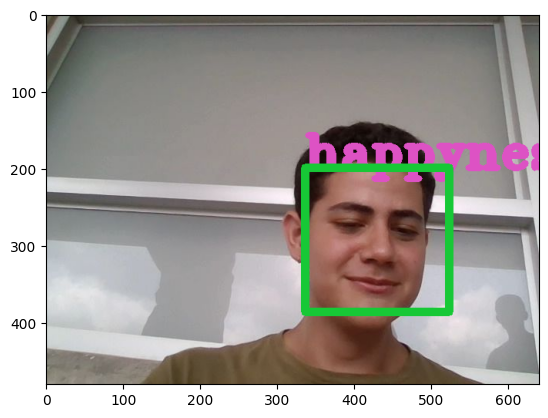

Ubicación del rostro: [[294 212 184 184]]
1/1 [==============================] - 0s 63ms/step
Predicciones:  [[0.07920221 0.00223667 0.27305028 0.01113975 0.44467652 0.011552
  0.17814259]]
4 [0.07920221 0.00223667 0.27305028 0.01113975 0.44467652 0.011552
 0.17814259]
Predicciones: {'angry': 0.07920221, 'disgust': 0.0022366713, 'fear': 0.27305028, 'happiness': 0.011139751, 'sadness': 0.44467652, 'surprise': 0.0115519995, 'neutral': 0.17814259}
sadness


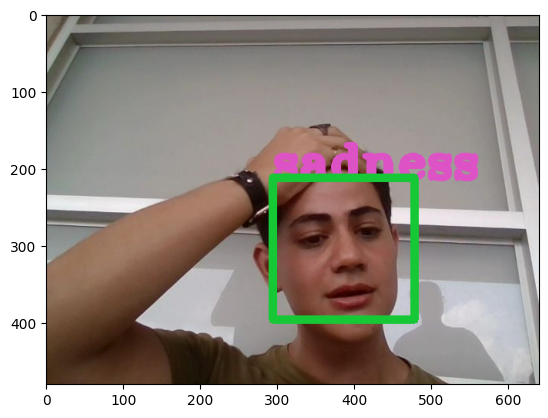

Ubicación del rostro: [[330 210 194 194]]
1/1 [==============================] - 0s 59ms/step
Predicciones:  [[0.28274506 0.27437928 0.30457914 0.00133428 0.10308    0.02954355
  0.00433869]]
2 [0.28274506 0.27437928 0.30457914 0.00133428 0.10308    0.02954355
 0.00433869]
Predicciones: {'angry': 0.28274506, 'disgust': 0.27437928, 'fear': 0.30457914, 'happiness': 0.0013342813, 'sadness': 0.103080004, 'surprise': 0.029543549, 'neutral': 0.004338686}
fear


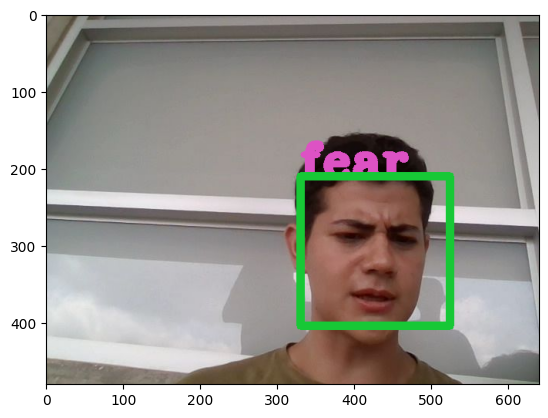

Ubicación del rostro: [[309 223 196 196]]
1/1 [==============================] - 0s 141ms/step
Predicciones:  [[0.05537353 0.00442128 0.0199388  0.7703948  0.07351412 0.00258571
  0.07377178]]
3 [0.05537353 0.00442128 0.0199388  0.7703948  0.07351412 0.00258571
 0.07377178]
Predicciones: {'angry': 0.055373527, 'disgust': 0.0044212844, 'fear': 0.019938802, 'happiness': 0.7703948, 'sadness': 0.07351412, 'surprise': 0.002585707, 'neutral': 0.07377178}
happyness


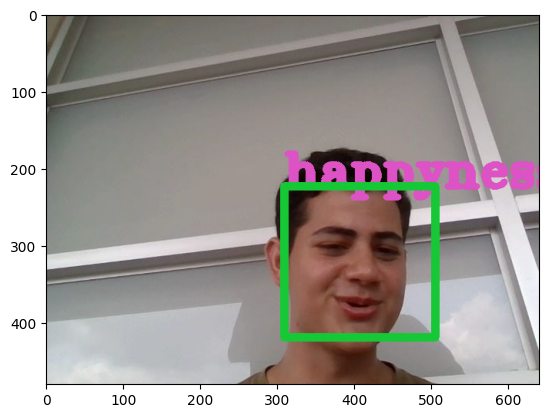

Ubicación del rostro: [[331 236 169 169]]
1/1 [==============================] - 0s 62ms/step
Predicciones:  [[0.20284353 0.0140917  0.11433623 0.19020273 0.26728082 0.01383678
  0.19740823]]
4 [0.20284353 0.0140917  0.11433623 0.19020273 0.26728082 0.01383678
 0.19740823]
Predicciones: {'angry': 0.20284353, 'disgust': 0.014091701, 'fear': 0.11433623, 'happiness': 0.19020273, 'sadness': 0.26728082, 'surprise': 0.0138367815, 'neutral': 0.19740823}
sadness


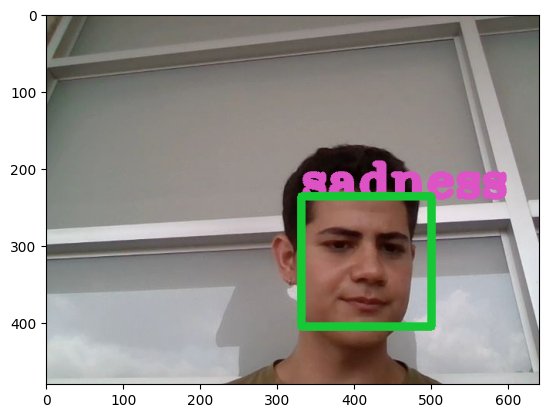

Ubicación del rostro: [[301 196 155 155]]
1/1 [==============================] - 0s 60ms/step
Predicciones:  [[0.03717956 0.00184207 0.0379573  0.57888097 0.07031484 0.01988205
  0.25394323]]
3 [0.03717956 0.00184207 0.0379573  0.57888097 0.07031484 0.01988205
 0.25394323]
Predicciones: {'angry': 0.03717956, 'disgust': 0.0018420743, 'fear': 0.037957296, 'happiness': 0.57888097, 'sadness': 0.07031484, 'surprise': 0.019882048, 'neutral': 0.25394323}
happyness


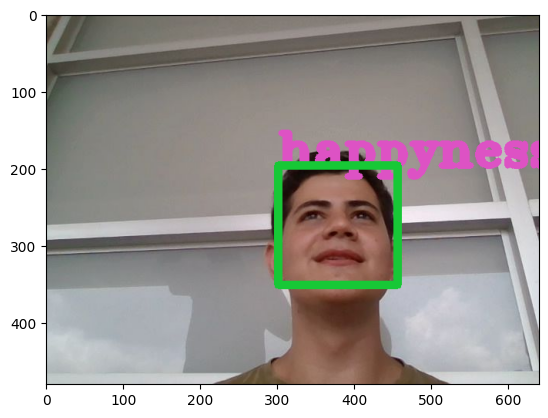

Ubicación del rostro: [[323 228 175 175]]
1/1 [==============================] - 0s 62ms/step
Predicciones:  [[0.1049236  0.00635025 0.04898696 0.4458515  0.1510899  0.00876169
  0.23403607]]
3 [0.1049236  0.00635025 0.04898696 0.4458515  0.1510899  0.00876169
 0.23403607]
Predicciones: {'angry': 0.1049236, 'disgust': 0.0063502514, 'fear': 0.048986964, 'happiness': 0.4458515, 'sadness': 0.1510899, 'surprise': 0.008761686, 'neutral': 0.23403607}
happyness


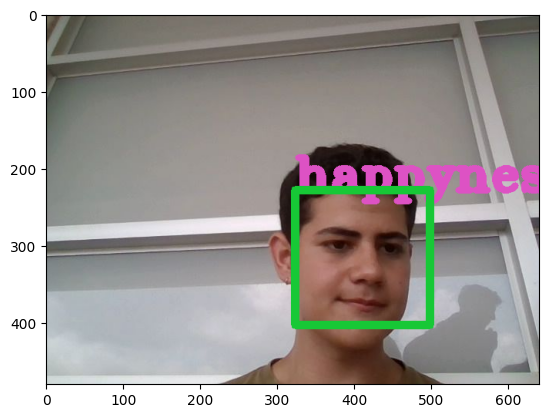

Digite la cédula de la persona a entrevistar: 2


FileExistsError: ignored

In [ ]:
#ask for the id (cedula) of the person who is interviewed
p_entrevistada = str(input("Digite la cédula de la persona a entrevistar: "))

#creat a directory to save the images
#nombre_carpeta = p_entrevistada
ruta_carpeta = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + p_entrevistada
os.makedirs(ruta_carpeta)

#declare the rute, the name and the extension of the file that will contains the coordenates and images
ruta_docs = ruta_carpeta + '.bin'
with open(ruta_docs, 'wb') as f:
  #pass for only create the file and do nothing else
  pass

ruta_emote = ruta_carpeta + 'emociones.bin'
with open(ruta_emote, 'wb') as f:
  #pass for only create the file and do nothing else
  pass

ruta_felicidad = ruta_carpeta + 'felicidad.bin'
with open(ruta_felicidad, 'wb') as f:
  #pass for only create the file and do nothing else
  pass

from tensorflow.python.ops.math_ops import sign
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
j = 5

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  img_copy = img

  # create transparent overlay for bounding box
  bbox_array = np.zeros([480,640,4], dtype=np.uint8)


  if count == j: #El tiempo para capturar el frame y procesarlo
    #Este sería la ruta de la imagen guardada
    image_path = ruta_carpeta + '/' + str(j) +  '.jpg'
    #se guarda el fotograma con el número del contador i
    cv2.imwrite(image_path , img) 

    #Detectar los rostros usando Face Haar Cascade
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #En faces_deteted se encuentran los rotros detectados
    faces_detected = face_haar_cascade.detectMultiScale(gray_image,1.32,5)
    #Save the coordenates in saces_detected in the file .bin
    with open(ruta_docs, 'ab') as f:
      pickle.dump(faces_detected, f)
    #Imprimir ubicación de los rostros en la imagen
    print("Ubicación del rostro:", faces_detected)

    im2Display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imTemp = im2Display.copy()

    #Hacer un rectángulo en cada rostro detectado en la imagen
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(img,(x,y), (x+w,y+h), (255,0,0), thickness=7)

        roi_gray=gray_image[y:y+w,x:x+h]
        roi_gray=cv2.resize(roi_gray,(48,48))

        #Processes the image and adjust it to pass it to the model
        image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
       
        image_pixels = np.expand_dims(image_pixels, axis = 0)
        image_pixels /= 255

        #Obtener las emociones para cada rostro detectado en la imagen
        #Get the prediction of the model
        predictions = model.predict(image_pixels)
        #Mostrar todas las emociones detectadas
        print("Predicciones: ", predictions)
        #Mostrar la emoción más significativa (con el valor más alto)
        max_index = np.argmax(predictions[0])
        print(max_index, predictions[0])
        #El orden en que vienen las emociones
        emotion_detection = ('angry', 'disgust', 'fear', 'happyness', 'sadness', 'surprise', 'neutral')

        emotion_prediction = emotion_detection[max_index]
        #Crear un diccionario para almacenar la emoción y el valor para la emoción
        
        frame_dic = dict(
            angry = predictions[0][0],
            disgust = predictions[0][1],
            fear = predictions[0][2],            
            happiness = predictions[0][3],
            sadness = predictions[0][4],
            surprise = predictions[0][5],
            neutral = predictions[0][6]) 
        emociones = "Predicciones: " + str(frame_dic)
        emote = "Emociones: " + str(frame_dic)
        #felicidad = frame_dic[predictions[0][3]]
        felicidad = frame_dic['happiness']
        print(emociones)
        #Save the coordenates in saces_detected in the file .bin
        with open(ruta_docs, 'ab') as f:
          pickle.dump(emociones, f)
        print(emotion_prediction)
        #Entrevistados.append(frame_dic)
        with open(ruta_emote, 'ab') as f:
          pickle.dump(emote, f)
        with open(ruta_felicidad, 'ab') as f:
          pickle.dump(felicidad, f)

        
        
        #Mostrar en la imagen un texto de la emoción más significativa
        ubicacion = (x,y)
        font = cv2.FONT_HERSHEY_TRIPLEX
        tamañoLetra = 2
        colorLetra = (221,82,196)
        grosorLetra = 7
        #Escribir texto con la emoción más significativa
        cv2.putText(imTemp, emotion_prediction, ubicacion, font, tamañoLetra, colorLetra, grosorLetra)
        pt1 = (x, y)
        pt2 = (x+w, y+h)
        color = (23,200,54)
        thickness = 10
        cv2.rectangle(imTemp, pt1, pt2, color, thickness)

    #Mostrar la imagen con los cuadros en los rostros y el texto de la emoción más significativa
    plt.imshow(imTemp)
    plt.show()

    j +=5
  count +=1

###Mostrar las coordenadas y rostro

[[242 190 211 211]]
Predicciones: {'angry': 0.01416988, 'disgust': 0.00018868032, 'fear': 0.005826714, 'happiness': 0.4245997, 'sadness': 0.023158083, 'surprise': 0.0023651544, 'neutral': 0.5296917}


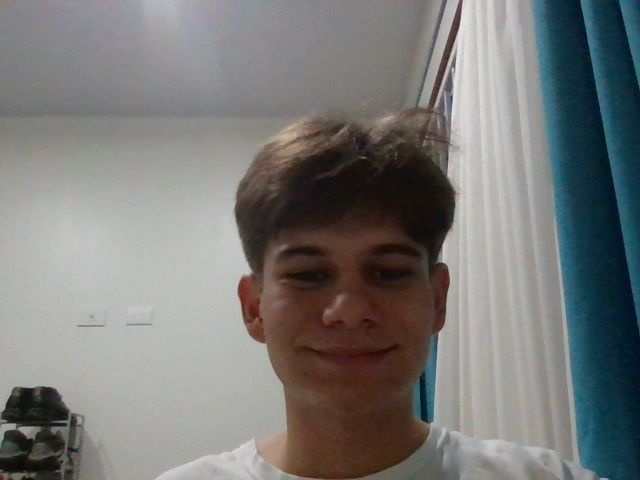

[[250 202 204 204]]
Predicciones: {'angry': 0.008715666, 'disgust': 0.00015317636, 'fear': 0.004007763, 'happiness': 0.6602853, 'sadness': 0.015698101, 'surprise': 0.0021887445, 'neutral': 0.30895123}


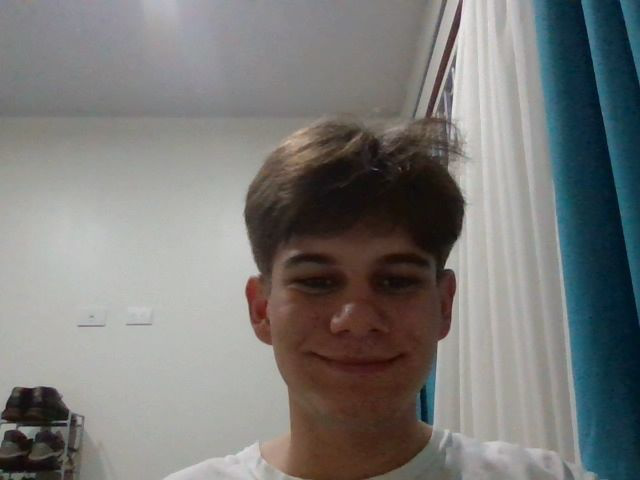

[[227 204 226 226]]
Predicciones: {'angry': 0.01737117, 'disgust': 0.00038179723, 'fear': 0.011643975, 'happiness': 0.47883222, 'sadness': 0.051146973, 'surprise': 0.0027236044, 'neutral': 0.43790027}


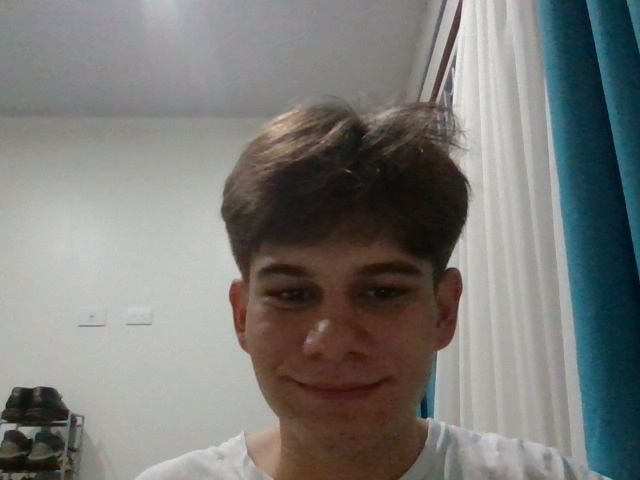

In [ ]:
x = str(input("Digite la cedula de la persona que quiere imprimirse: "))
ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'
dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '/'

# Obtener la lista de archivos .jpg en el directorio
imagenes = [archivo for archivo in os.listdir(dir_jpg) if archivo.endswith('.jpg')]

# Crear un iterador para recorrer la lista de imágenes
iterador_imagenes = iter(imagenes)

# Abrir el archivo en modo de lectura binaria
with open(ruta_archivo, 'rb') as f:
    # Iterar sobre los elementos del archivo
    i = 0
    while True:
        try:
            # Cargar el siguiente elemento del archivo utilizando pickle
            elemento = pickle.load(f)
            # Imprimir el elemento como una cadena de texto
            print(elemento)
            i += 1
            if i % 2 == 0:
                # Imprimir una imagen cada dos líneas
                try:
                    # Obtener el siguiente archivo .jpg de la lista
                    imagen = next(iterador_imagenes)
                    # Abrir la imagen y mostrarla
                    img_path = os.path.join(dir_jpg, imagen)
                    with Image.open(img_path) as img:
                        img.show()
                except StopIteration:
                    # Si no quedan más imágenes en la lista, salir del bucle
                    break
        except EOFError:
            # Se alcanzó el final del archivo
            break

###Funciones


In [ ]:
def imprimir_archivo(x):
    ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'
    dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '/'

    # Obtener la lista de archivos .jpg en el directorio
    imagenes = [archivo for archivo in os.listdir(dir_jpg) if archivo.endswith('.jpg')]

    # Crear un iterador para recorrer la lista de imágenes
    iterador_imagenes = iter(imagenes)

    # Abrir el archivo en modo de lectura binaria
    with open(ruta_archivo, 'rb') as f:
        # Iterar sobre los elementos del archivo
        i = 0
        while True:
            try:
                # Cargar el siguiente elemento del archivo utilizando pickle
                elemento = pickle.load(f)
                # Imprimir el elemento como una cadena de texto
                print(elemento)
                i += 1
                if i % 2 == 0:
                    # Imprimir una imagen cada dos líneas
                    try:
                        # Obtener el siguiente archivo .jpg de la lista
                        imagen = next(iterador_imagenes)
                        # Abrir la imagen y mostrarla
                        img_path = os.path.join(dir_jpg, imagen)
                        with Image.open(img_path) as img:
                            img.show()
                    except StopIteration:
                        # Si no quedan más imágenes en la lista, salir del bucle
                        break
            except EOFError:
                # Se alcanzó el final del archivo
                break

###Consultas

Genero: masculino /  Identificación: / 2023141516 Nombre: Samuel Mendez / Fecha de nacimiento: 12/02/2004 / Edad: [19] / Nacionalidad: Costarricense / Números:  {21212121, 20202020} / Emails: ['cluisandres486@gmail.com, lemendez@estudiantec.cr'] / Dirección:  1 Km al norte de la Escuela Buenos Aires de Venecia / Estado civil: Soltereo / Hijos:  {'Cantidad': [1], 'Genero': ['masculino'], 'Fecha de nacimiento': ['04/1/2012', '02/08/2017']}
[[287 222 166 166]]
Predicciones: {'angry': 0.031268064, 'disgust': 0.0013074874, 'fear': 0.017282322, 'happiness': 0.7120733, 'sadness': 0.049512602, 'surprise': 0.006281089, 'neutral': 0.18227507}


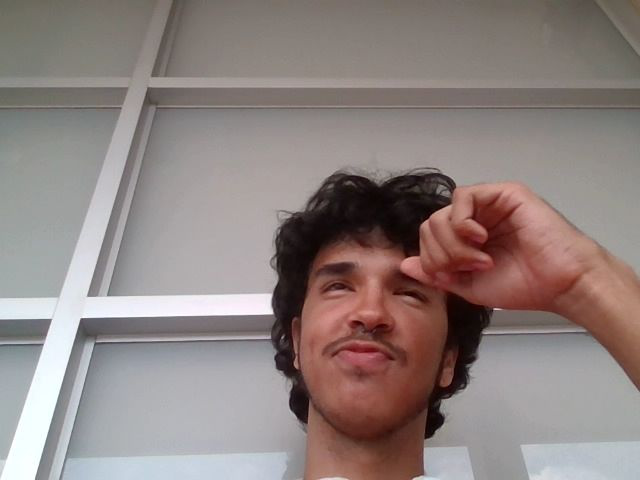

[[287 204 203 203]]
Predicciones: {'angry': 8.000052e-05, 'disgust': 2.55991e-07, 'fear': 3.0608036e-05, 'happiness': 0.9945446, 'sadness': 4.378833e-05, 'surprise': 0.00012519851, 'neutral': 0.005175577}


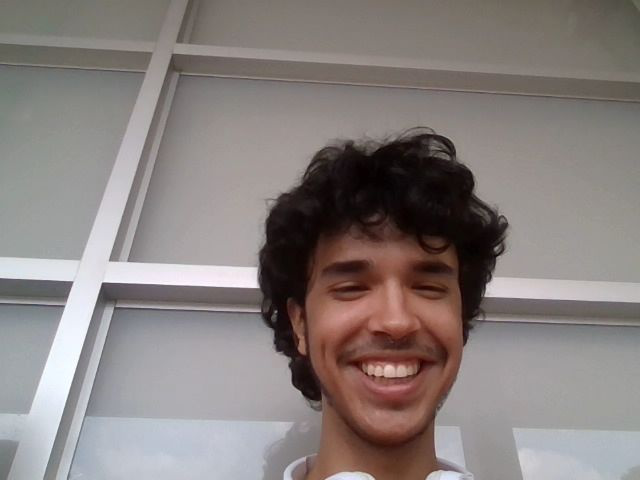

[[291 222 174 174]]
Predicciones: {'angry': 0.03315598, 'disgust': 0.00047905417, 'fear': 0.057744134, 'happiness': 0.08742851, 'sadness': 0.11188516, 'surprise': 0.016905475, 'neutral': 0.69240165}


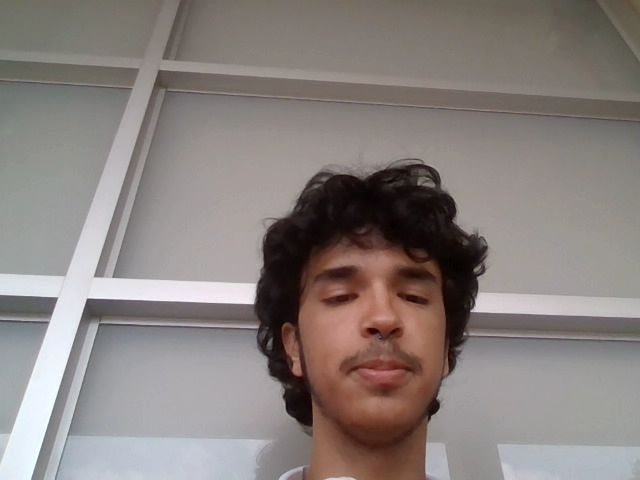

()
[[345 218 182 182]]


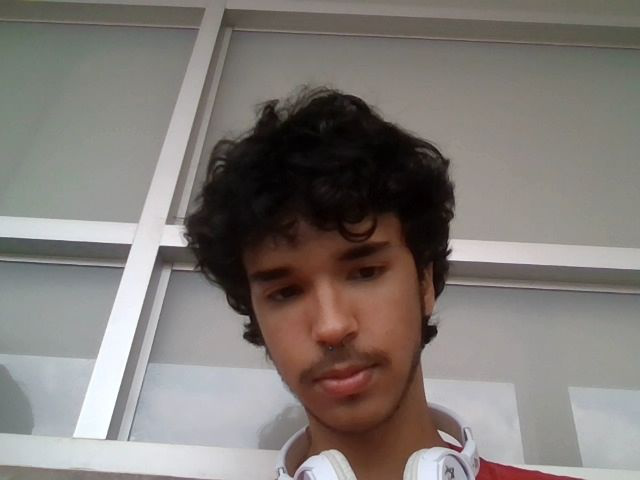

Predicciones: {'angry': 0.022046018, 'disgust': 0.0005472238, 'fear': 0.02461378, 'happiness': 0.3744079, 'sadness': 0.04585783, 'surprise': 0.017453209, 'neutral': 0.515074}
[[281 136 196 196]]


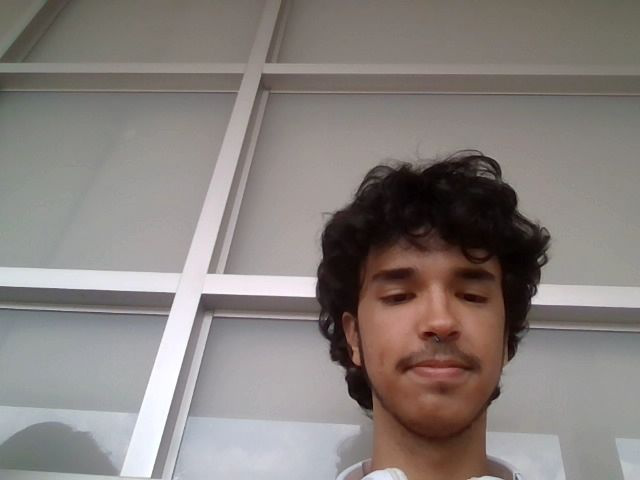

Predicciones: {'angry': 0.05618108, 'disgust': 0.0010420295, 'fear': 0.08261356, 'happiness': 0.07969399, 'sadness': 0.18708834, 'surprise': 0.011845934, 'neutral': 0.58153504}
[[284 140 201 201]]


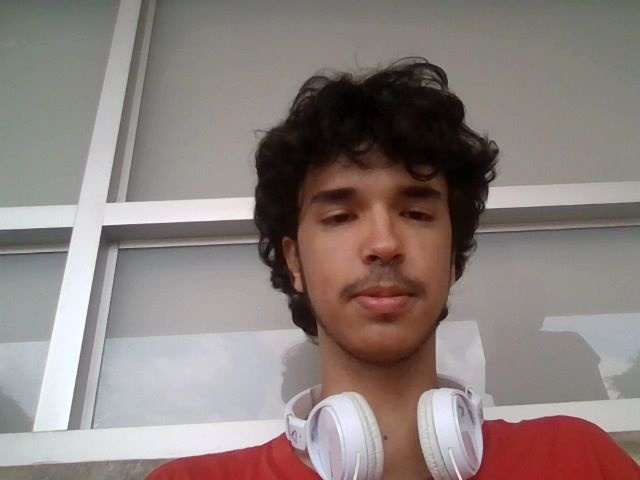

Predicciones: {'angry': 0.047764976, 'disgust': 0.002514737, 'fear': 0.05456888, 'happiness': 0.41740623, 'sadness': 0.15436651, 'surprise': 0.013974165, 'neutral': 0.3094045}
[[298 142 185 185]]


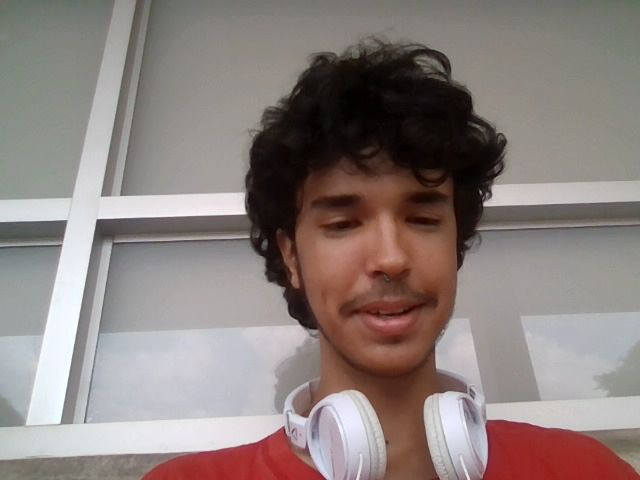

Predicciones: {'angry': 0.09242606, 'disgust': 0.0027584187, 'fear': 0.13088627, 'happiness': 0.085685454, 'sadness': 0.2959139, 'surprise': 0.013642004, 'neutral': 0.3786879}
[[311 142 194 194]]


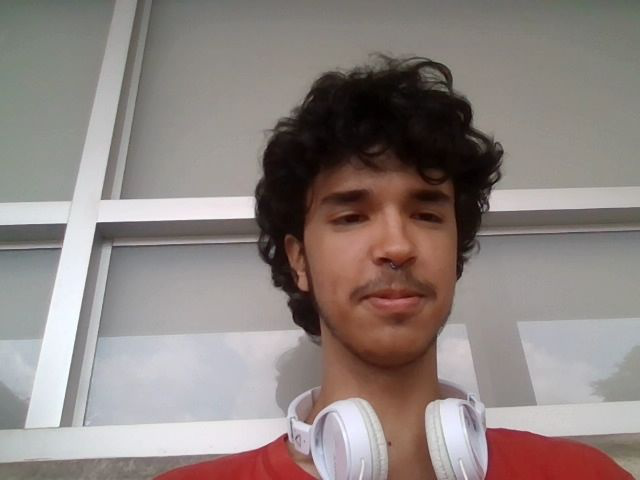

Predicciones: {'angry': 0.04436283, 'disgust': 0.0018382564, 'fear': 0.037555993, 'happiness': 0.4007828, 'sadness': 0.10634058, 'surprise': 0.010474835, 'neutral': 0.3986448}
[[295 154 194 194]]


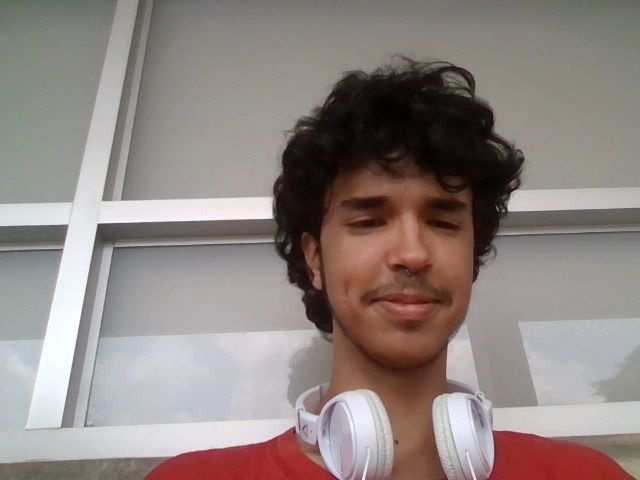

Predicciones: {'angry': 0.09139438, 'disgust': 0.002551871, 'fear': 0.28930342, 'happiness': 0.008849285, 'sadness': 0.41683945, 'surprise': 0.013411971, 'neutral': 0.17764959}
Genero: masculino /  Identificación: / 2023074542 Nombre: Maikol Flores / Fecha de nacimiento: 15/11/2004 / Edad: [18] / Nacionalidad: Costarricense / Números:  {60252260} / Emails: ['janpaulo1115@gmail.com, janmolina@estudiantec.cr'] / Dirección:  100mts al norte y 100mts al este de la Escuela Viento Fresco / Estado civil: Soltero / Hijos:  {'Cantidad': [2], 'Genero': ['femenino', 'masculino'], 'Fecha de nacimiento': ['01/11/2011', '19/09/2018'], 'Coordenadas': ''}
[[293 178 187 187]]
Predicciones: {'angry': 0.0005337127, 'disgust': 9.7133425e-06, 'fear': 0.0005330819, 'happiness': 0.98821974, 'sadness': 0.0015938709, 'surprise': 0.00022682354, 'neutral': 0.008883131}


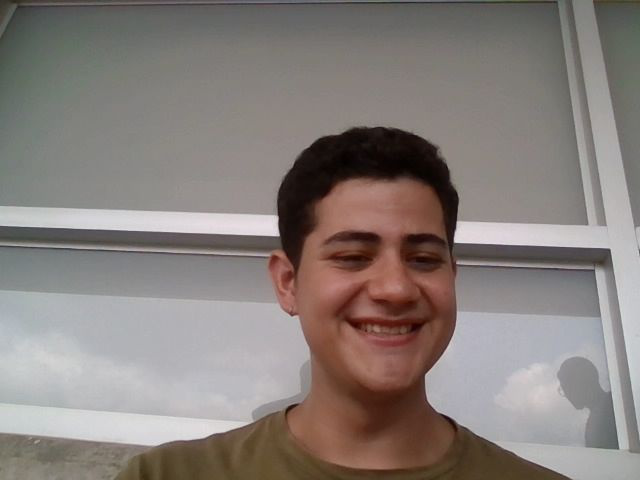

[[301 189 190 190]]
Predicciones: {'angry': 0.11275947, 'disgust': 0.009036167, 'fear': 0.11731043, 'happiness': 0.23512903, 'sadness': 0.35444146, 'surprise': 0.009248003, 'neutral': 0.1620754}


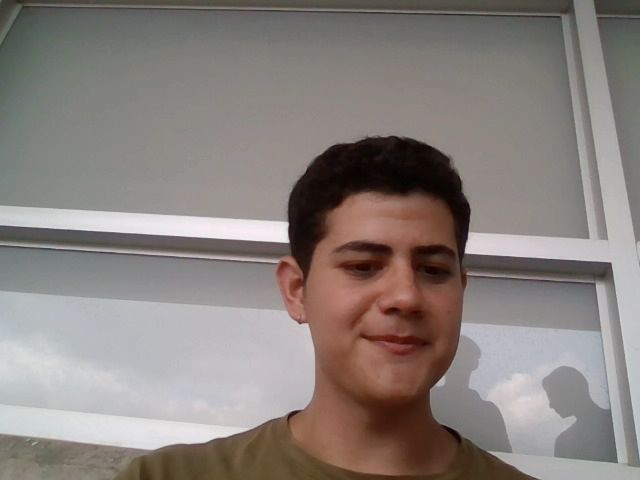

[[295 196 180 180]]
Predicciones: {'angry': 0.1660691, 'disgust': 0.013861374, 'fear': 0.16131665, 'happiness': 0.13112362, 'sadness': 0.343711, 'surprise': 0.015957654, 'neutral': 0.16796066}


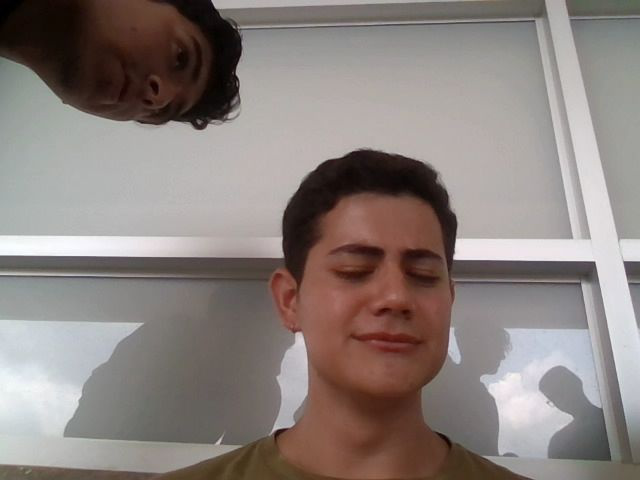

[[336 199 187 187]]
Predicciones: {'angry': 0.049136948, 'disgust': 0.00548702, 'fear': 0.041844524, 'happiness': 0.5731804, 'sadness': 0.23000884, 'surprise': 0.003296194, 'neutral': 0.09704603}


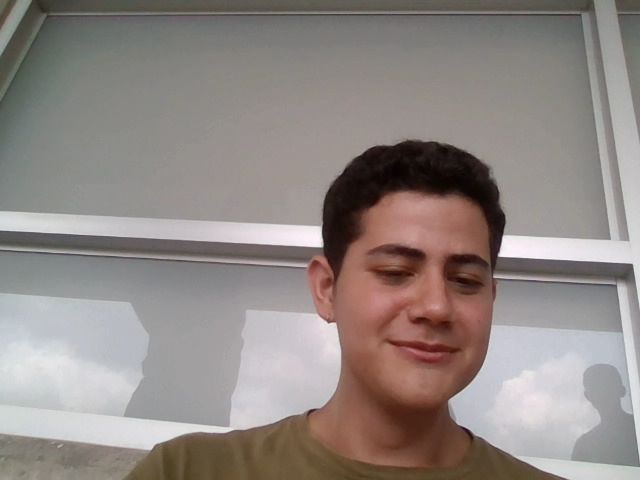

[[294 212 184 184]]
Predicciones: {'angry': 0.07920221, 'disgust': 0.0022366713, 'fear': 0.27305028, 'happiness': 0.011139751, 'sadness': 0.44467652, 'surprise': 0.0115519995, 'neutral': 0.17814259}


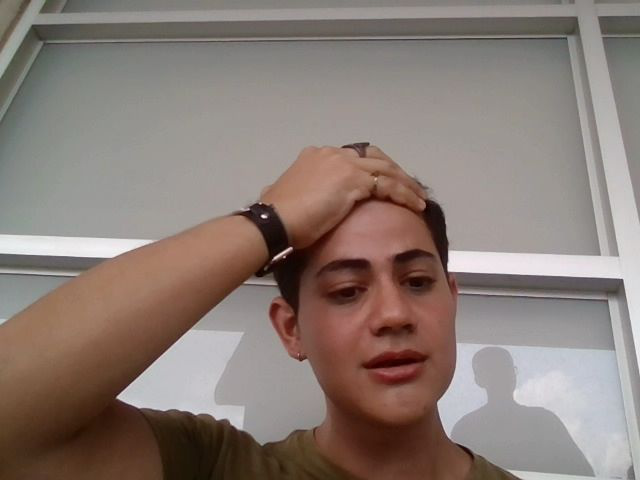

[[330 210 194 194]]
Predicciones: {'angry': 0.28274506, 'disgust': 0.27437928, 'fear': 0.30457914, 'happiness': 0.0013342813, 'sadness': 0.103080004, 'surprise': 0.029543549, 'neutral': 0.004338686}


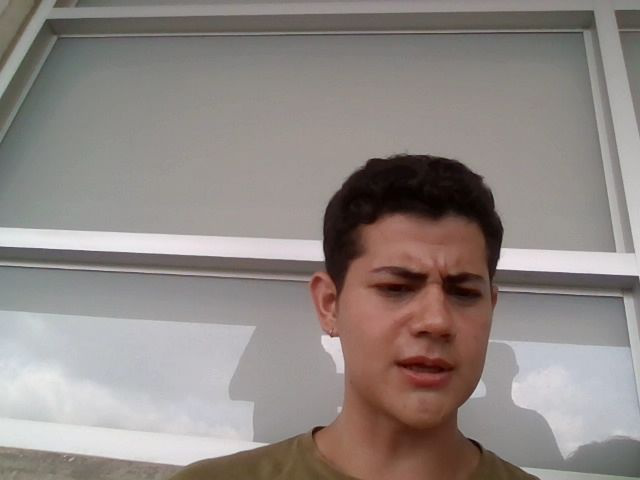

[[309 223 196 196]]
Predicciones: {'angry': 0.055373527, 'disgust': 0.0044212844, 'fear': 0.019938802, 'happiness': 0.7703948, 'sadness': 0.07351412, 'surprise': 0.002585707, 'neutral': 0.07377178}


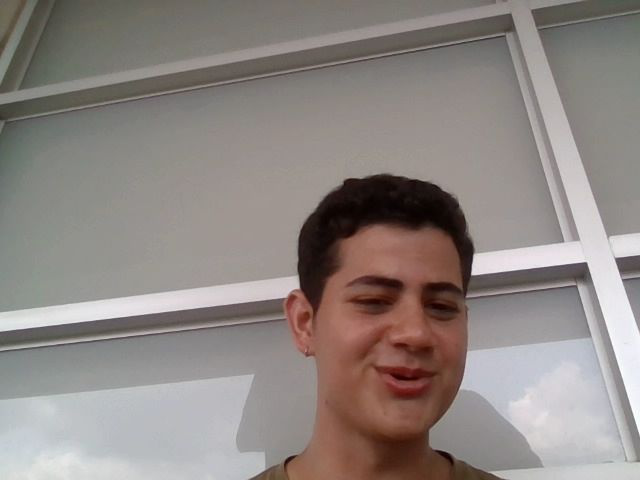

[[331 236 169 169]]
Predicciones: {'angry': 0.20284353, 'disgust': 0.014091701, 'fear': 0.11433623, 'happiness': 0.19020273, 'sadness': 0.26728082, 'surprise': 0.0138367815, 'neutral': 0.19740823}


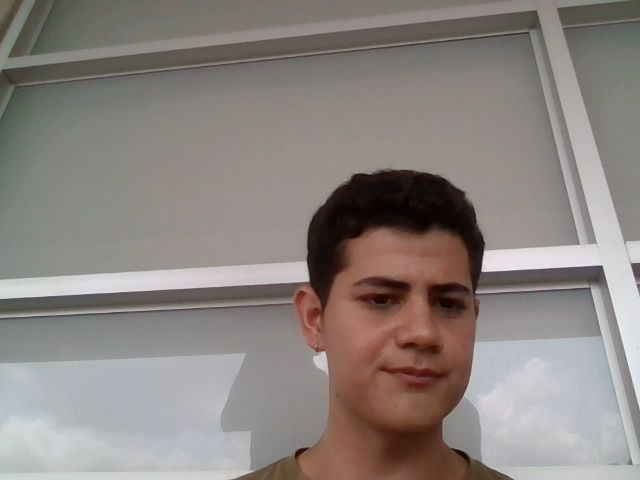

[[301 196 155 155]]
Predicciones: {'angry': 0.03717956, 'disgust': 0.0018420743, 'fear': 0.037957296, 'happiness': 0.57888097, 'sadness': 0.07031484, 'surprise': 0.019882048, 'neutral': 0.25394323}


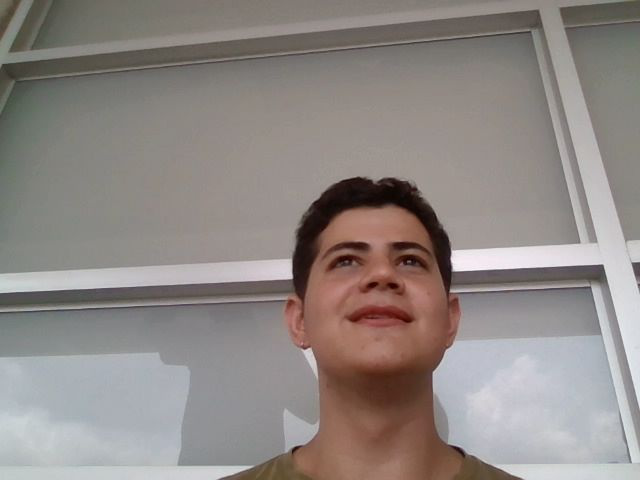

[[323 228 175 175]]
Predicciones: {'angry': 0.1049236, 'disgust': 0.0063502514, 'fear': 0.048986964, 'happiness': 0.4458515, 'sadness': 0.1510899, 'surprise': 0.008761686, 'neutral': 0.23403607}


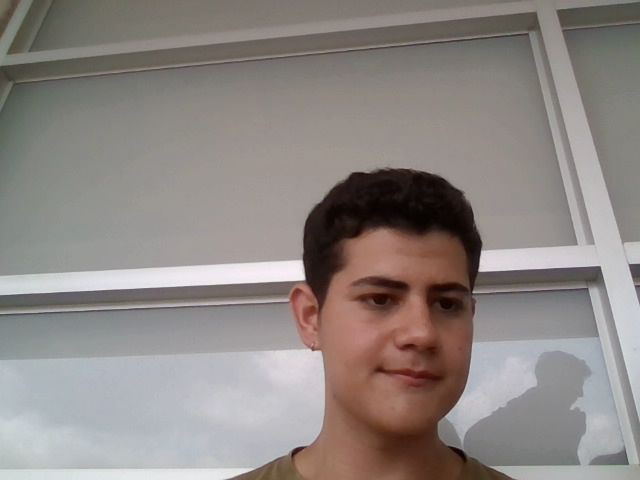

In [ ]:
#Consulta 1
"This function shows the recopilate personal information from the first interviewee"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información1(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  identificación=entrevista1["Identificación"]
  Nombre=entrevista1["Nombre"]
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  Edad=entrevista1["Edad"]
  Nacionalidad=entrevista1["Nacionalidad"]
  Números_de_teléfono=entrevista1["Números de teléfono"]
  emails=entrevista1["emails"]
  dirección=entrevista1["dirección"]
  Estado_civil=entrevista1["Estado civil"]
  Hijos=entrevista1["Hijos"]
  print("Genero:",genero,"/ ","Identificación:","/",identificación,"Nombre:",Nombre,"/ " "Fecha de nacimiento:",Fecha_de_nacimiento,"/ " "Edad:",Edad,"/ ""Nacionalidad:",Nacionalidad, "/ ""Números: ",Números_de_teléfono, "/ ""Emails:",emails,"/ ""Dirección: " ,dirección, "/ ""Estado civil:",Estado_civil,"/ " "Hijos: ",Hijos)
  x1 = str(identificación)
  imprimir_archivo(x1)
  return 
"This function shows the recopilate personal information from the first interviewee"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información2(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista2"]
  genero=entrevista1["Genero"]
  identificación=entrevista1["Identificación"]
  Nombre=entrevista1["Nombre"]
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  Edad=entrevista1["Edad"]
  Nacionalidad=entrevista1["Nacionalidad"]
  Números_de_teléfono=entrevista1["Números de teléfono"]
  emails=entrevista1["emails"]
  dirección=entrevista1["dirección"]
  Estado_civil=entrevista1["Estado civil"]
  Hijos=entrevista1["Hijos"]
  print("Genero:",genero,"/ ","Identificación:","/",identificación,"Nombre:",Nombre,"/ " "Fecha de nacimiento:",Fecha_de_nacimiento,"/ " "Edad:",Edad,"/ ""Nacionalidad:",Nacionalidad, "/ ""Números: ",Números_de_teléfono, "/ ""Emails:",emails,"/ ""Dirección: " ,dirección, "/ ""Estado civil:",Estado_civil,"/ " "Hijos: ",Hijos)
  x1 = str(identificación)
  imprimir_archivo(x1)
  return
información1(lista_principal)
información2(lista_principal)

In [ ]:
#Consulta 2
lista1=[]
lista2=[]
lista_edad=[]
edad1=[]
edad2=[]
"This function shows the recopilate personal information from the first interviewee and put it in a list, also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información1(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  lista1.append(genero)
  identificación=entrevista1["Identificación"]
  lista1.append(identificación)
  Nombre=entrevista1["Nombre"]
  lista1.append(Nombre)
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  lista1.append(Fecha_de_nacimiento)
  Edad=entrevista1["Edad"]
  lista1.append(Edad)
  lista_edad.append(Edad)
  edad1=Edad
  Nacionalidad=entrevista1["Nacionalidad"]
  lista1.append(Nacionalidad)
  Números_de_teléfono=entrevista1["Números de teléfono"]
  lista1.append(Números_de_teléfono)
  emails=entrevista1["emails"]
  lista1.append(emails)
  dirección=entrevista1["dirección"]
  lista1.append(dirección)
  Estado_civil=entrevista1["Estado civil"]
  lista1.append(Estado_civil)
  Hijos=entrevista1["Hijos"]
  lista1.append(Hijos)
  return 
información1(lista_principal)
"This function shows the recopilate personal information from the second interviewee and put it in a list also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información2(x):
  y=entrevistas
  entrevista2=entrevistas["entrevista2"]
  genero=entrevista2["Genero"]
  lista2.append(genero)
  identificación=entrevista2["Identificación"]
  lista2.append(identificación)
  Nombre=entrevista2["Nombre"]
  lista2.append(Nombre)
  Fecha_de_nacimiento=entrevista2["Fecha de nacimiento"]
  lista2.append(Fecha_de_nacimiento)
  Edad=entrevista2["Edad"]
  lista2.append(Edad)
  edad2.append(Edad)
  lista_edad.append(Edad)
  Nacionalidad=entrevista2["Nacionalidad"]
  lista2.append(Nacionalidad)
  Números_de_teléfono=entrevista2["Números de teléfono"]
  lista2.append(Números_de_teléfono)
  emails=entrevista2["emails"]
  lista2.append(emails)
  dirección=entrevista2["dirección"]
  lista2.append(dirección)
  Estado_civil=entrevista2["Estado civil"]
  lista2.append(Estado_civil)
  Hijos=entrevista2["Hijos"]
  lista2.append(Hijos)
  return 
información2(lista_principal)
"This function gets the bigger number of the list of age"
"Arguments:"
"lista_edad"
"Returns"
"The bigger number"
def mayor_lista(lista):
    if len(lista)==0:
        return (None)
    else:
        mayor=lista[0]
        for x in lista[1:]:
            if x>mayor:
                mayor=x
        return(mayor) 
mayor_lista(lista_edad)
"This function order the list of age ascending and if the conditional is completated, returns the information of the entervies in order"
"Arguments:"
"The list of the ages"
"Returns:"
"The list of the persons orden of a ascending way for the age"
def ordenamiento_insercion(x):
    cont=0
    nueva_lista = []
    while len(x)>0:
        mayor=mayor_lista(x)
        nueva_lista.insert(0,mayor)
        x.remove(mayor)
    if nueva_lista[cont]<nueva_lista[cont+1]:
      if nueva_lista[cont]==edad2[cont]:
        for e in lista2:
          print(e)
        for e in lista2:
          if e == 2023141516:
            tem = str(e)
            imprimir_archivo(tem)
        for e in lista1:
          print(e)
        for e in lista1:
            if e == 2023074542:
              tem = str(e)
              imprimir_archivo(tem)
      else:
        for e in lista1:
          print(e)
        for e in lista1:
          if e == 2023074542:
            tem = str(e)
            imprimir_archivo(tem)
        for e in lista2:
          print(e)
        for e in lista2:
            if e == 2023141516:
              tem = str(e)
              imprimir_archivo(tem)
ordenamiento_insercion(lista_edad)

masculino
2023074542
Maikol Flores
15/11/2004
[18]
Costarricense
{60252260}
['janpaulo1115@gmail.com, janmolina@estudiantec.cr']
100mts al norte y 100mts al este de la Escuela Viento Fresco
Soltero
{'Cantidad': [2], 'Genero': ['femenino', 'masculino'], 'Fecha de nacimiento': ['01/11/2011', '19/09/2018'], 'Coordenadas': ''}
masculino
2023141516
Samuel Mendez
12/02/2004
[19]
Costarricense
{21212121, 20202020}
['cluisandres486@gmail.com, lemendez@estudiantec.cr']
1 Km al norte de la Escuela Buenos Aires de Venecia
Soltereo
{'Cantidad': [1], 'Genero': ['masculino'], 'Fecha de nacimiento': ['04/1/2012', '02/08/2017']}


In [ ]:
#Consulta 3
lista1=[]
lista2=[]
lista_edad=[]
edad2=[]
"This function shows the recopilate personal information from the first interviewee and put it in a list, also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información1(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  lista1.append(genero)
  identificación=entrevista1["Identificación"]
  lista1.append(identificación)
  Nombre=entrevista1["Nombre"]
  lista1.append(Nombre)
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  lista1.append(Fecha_de_nacimiento)
  Edad=entrevista1["Edad"]
  lista1.append(Edad)
  lista_edad.append(Edad)
  Nacionalidad=entrevista1["Nacionalidad"]
  lista1.append(Nacionalidad)
  Números_de_teléfono=entrevista1["Números de teléfono"]
  lista1.append(Números_de_teléfono)
  emails=entrevista1["emails"]
  lista1.append(emails)
  dirección=entrevista1["dirección"]
  lista1.append(dirección)
  Estado_civil=entrevista1["Estado civil"]
  lista1.append(Estado_civil)
  Hijos=entrevista1["Hijos"]
  lista1.append(Hijos)
  return 
información1(lista_principal)
"This function shows the recopilate personal information from the second interviewee and put it in a list also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información2(x):
  y=entrevistas
  entrevista2=entrevistas["entrevista2"]
  genero=entrevista2["Genero"]
  lista2.append(genero)
  identificación=entrevista2["Identificación"]
  lista2.append(identificación)
  Nombre=entrevista2["Nombre"]
  lista2.append(Nombre)
  Fecha_de_nacimiento=entrevista2["Fecha de nacimiento"]
  lista2.append(Fecha_de_nacimiento)
  Edad=entrevista2["Edad"]
  lista2.append(Edad)
  lista_edad.append(Edad)
  edad2.append(Edad)
  Nacionalidad=entrevista2["Nacionalidad"]
  lista2.append(Nacionalidad)
  Números_de_teléfono=entrevista2["Números de teléfono"]
  lista2.append(Números_de_teléfono)
  emails=entrevista2["emails"]
  lista2.append(emails)
  dirección=entrevista2["dirección"]
  lista2.append(dirección)
  Estado_civil=entrevista2["Estado civil"]
  lista2.append(Estado_civil)
  Hijos=entrevista2["Hijos"]
  lista2.append(Hijos)
  return 
información2(lista_principal)
"This is a bubble sort function that allows order the list of age "
"Arguments:"
"List of age"
"Returns: "
"The list of age order in a ascending way"
def ordenamiento_burbuja(x):
    pasadas=len(x)-1
    cont=0
    lista_principal=[]
    while pasadas>0:
        pos=0
        while pos<pasadas:
            if x[pos]>x[pos+1]:
                temp=x[pos]
                x[pos]=x[pos+1]
                x[pos+1]=temp
            pos=pos+1
        pasadas=pasadas-1
    if x[cont]<x[cont+1]:
      if x[cont]==edad2[cont]:
        #lista_principal=lista2+lista1
        for e in lista2:
          print(e)
        for e in lista2:
          if e == 2023141516:
            tem = str(e)
            imprimir_archivo(tem)
        for e in lista1:
          print(e)
        for e in lista1:
            if e == 2023074542:
              tem = str(e)
              imprimir_archivo(tem)
      else:
        #lista_principal=lista1+lista2
        for e in lista1:
          print(e)
        for e in lista1:
          if e == 2023074542:
            tem = str(e)
            imprimir_archivo(tem)
        for e in lista2:
          print(e)
        for e in lista2:
            if e == 2023141516:
              tem = str(e)
              imprimir_archivo(tem)
   # return lista_principal
ordenamiento_burbuja(lista_edad)


masculino
2023074542
Maikol Flores
15/11/2004
[18]
Costarricense
{60252260}
['janpaulo1115@gmail.com, janmolina@estudiantec.cr']
100mts al norte y 100mts al este de la Escuela Viento Fresco
Soltero
{'Cantidad': [2], 'Genero': ['femenino', 'masculino'], 'Fecha de nacimiento': ['01/11/2011', '19/09/2018'], 'Coordenadas': ''}
masculino
2023141516
Samuel Mendez
12/02/2004
[19]
Costarricense
{21212121, 20202020}
['cluisandres486@gmail.com, lemendez@estudiantec.cr']
1 Km al norte de la Escuela Buenos Aires de Venecia
Soltereo
{'Cantidad': [1], 'Genero': ['masculino'], 'Fecha de nacimiento': ['04/1/2012', '02/08/2017']}


In [ ]:
#Consulta 4
lista1=[]
lista2=[]
lista_edad=[]
lista_prima=[]
edad2=0
"This function shows the recopilate personal information from the first interviewee and put it in a list, also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información1(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  lista1.append(genero)
  identificación=entrevista1["Identificación"]
  lista1.append(identificación)
  Nombre=entrevista1["Nombre"]
  lista1.append(Nombre)
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  lista1.append(Fecha_de_nacimiento)
  Edad=entrevista1["Edad"]
  lista1.append(Edad)
  lista_edad.append(Edad)
  Nacionalidad=entrevista1["Nacionalidad"]
  lista1.append(Nacionalidad)
  Números_de_teléfono=entrevista1["Números de teléfono"]
  lista1.append(Números_de_teléfono)
  emails=entrevista1["emails"]
  lista1.append(emails)
  dirección=entrevista1["dirección"]
  lista1.append(dirección)
  Estado_civil=entrevista1["Estado civil"]
  lista1.append(Estado_civil)
  Hijos=entrevista1["Hijos"]
  lista1.append(Hijos)
  return 
información1(lista_principal)
"This function shows the recopilate personal information from the second interviewee and put it in a list also put the age of the person in another list"
"Arguments:"
"The principal list of with all information of the interviewees"
"Return:"
"The information ordered"
def información2(x):
  y=entrevistas
  entrevista2=entrevistas["entrevista2"]
  genero=entrevista2["Genero"]
  lista2.append(genero)
  identificación=entrevista2["Identificación"]
  lista2.append(identificación)
  Nombre=entrevista2["Nombre"]
  lista2.append(Nombre)
  Fecha_de_nacimiento=entrevista2["Fecha de nacimiento"]
  lista2.append(Fecha_de_nacimiento)
  Edad=entrevista2["Edad"]
  lista2.append(Edad)
  lista_edad.append(Edad)
  edad2=Edad[0]
  Nacionalidad=entrevista2["Nacionalidad"]
  lista2.append(Nacionalidad)
  Números_de_teléfono=entrevista2["Números de teléfono"]
  lista2.append(Números_de_teléfono)
  emails=entrevista2["emails"]
  lista2.append(emails)
  dirección=entrevista2["dirección"]
  lista2.append(dirección)
  Estado_civil=entrevista2["Estado civil"]
  lista2.append(Estado_civil)
  Hijos=entrevista2["Hijos"]
  lista2.append(Hijos)
  return 
información2(lista_principal)
"This function partition the lista_edad in the values less than pivote and bigger than him"
"Arguments:"
"lista_edad"
"Returns:"
"The list partitioned"
def particiona_lista(lista):
    menores=list()
    mayores=list()
    pivote=lista[-1]
    for x in lista[:-1]:
        if x<pivote:
            menores.append(x)
        else:
            mayores.append(x) 
    return([menores,pivote,mayores])
particiona_lista(lista_edad)
"This function use the quicksort method to orden the list of age in a ascending way"
"Arguments:"
"list of age"
"Returns:"
"This return the list of age ordered in an ascending way"
def ordenamiento_quickSort(lista):
    cont=0
    lista_principal=[]
    if len(lista)>0:
        lista=particiona_lista(lista)
        while cont<len(lista):
            e=lista[cont]
            if type(e)==list:
                if len(e)==0:
                    del lista[cont]
                elif len(e)==1:
                    lista[cont]=e[0]
                    cont = cont + 1
                else:
                    lista=lista[:cont]+particiona_lista(e)+lista[cont+1:]
            else:
                cont=cont+1 
    else:
      False
    edad2=lista[0]
    if edad2==lista[0]:
      lista_principal=lista2+lista1
    else:
      lista_principal=lista1+lista2
    print(lista_principal)
    return lista_principal
ordenamiento_quickSort(lista_edad)
"This is a function that order a main list of information throught to determinated requerements"
"Arguments:"
"The father list (lista_princiapl)"
"Returns:"
"The information order by the requerements"
def listas(x):
  sublist1=[]
  aux1=[]
  listasemi1=[]
  sublist2=[]
  aux2=[]
  listasemi2=[]
  sublist3=[]
  aux3=[]
  listasemi3=[]
  listaux3=[]
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  sublist1.append(genero)
  sublist2.append(genero)
  sublist3.append(genero)
  identificación=entrevista1["Identificación"]
  sublist1.append(identificación)
  sublist2.append(identificación)
  sublist3.append(identificación)
  Nombre=entrevista1["Nombre"]
  sublist1.append(Nombre)
  sublist2.append(Nombre)
  sublist3.append(Nombre)
  Fecha_de_nacimiento=entrevista1["Fecha de nacimiento"]
  sublist1.append(Fecha_de_nacimiento)
  sublist2.append(Fecha_de_nacimiento)
  sublist3.append(Fecha_de_nacimiento)
  Edad=entrevista1["Edad"]
  sublist1.append(Edad)
  sublist2.append(Edad)
  sublist3.append(Edad)
  Nacionalidad=entrevista1["Nacionalidad"]
  sublist1.append(Nacionalidad)
  sublist2.append(Nacionalidad)
  sublist3.append(Nacionalidad)
  Números_de_teléfono=entrevista1["Números de teléfono"]
  sublist1.append(Números_de_teléfono)
  sublist2.append(Números_de_teléfono)
  sublist2.append(Números_de_teléfono)
  emails=entrevista1["emails"]
  sublist1.append(emails)
  sublist2.append(emails)
  sublist3.append(emails)
  dirección=entrevista1["dirección"]
  sublist1.append(dirección)
  sublist2.append(dirección)
  sublist3.append(dirección)
  Estado_civil=entrevista1["Estado civil"]
  sublist1.append(Estado_civil)
  sublist2.append(Estado_civil)
  sublist3.append(Estado_civil)
  Hijos=entrevista1["Hijos"]
  sublist1.append(Hijos)
  sublist2.append(Hijos)
  sublist3.append(Hijos)
  genero1=Hijos["Genero"]
  sublist1.append(genero1)
  sublist2.append(genero1)
  sublist3.append(genero1)
  for x in genero1:
    if "masculino" in genero1:
      break
    else:
      listasemi1.append(sublist1)
  for x in genero1:
    if "femenino" in x:
        break
    else:
        listasemi2.append(sublist2)
  for x in genero1:
    if "femenino" in genero1:
      listasemi3.append(sublist3)
      if "masculino" in genero1:
        listaux3=listasemi3
        break
    else:
      break
  entrevista2=entrevistas["entrevista2"]
  genero=entrevista1["Genero"]
  aux1.append(genero)
  aux1.append(genero)
  aux1.append(genero)
  identificación=entrevista1["Identificación"]
  aux1.append(identificación)
  aux1.append(identificación)
  aux1.append(identificación)
  Nombre=entrevista2["Nombre"]
  aux1.append(Nombre)
  aux2.append(Nombre)
  aux3.append(Nombre)
  Fecha_de_nacimiento=entrevista2["Fecha de nacimiento"]
  aux1.append(Fecha_de_nacimiento)
  aux2.append(Fecha_de_nacimiento)
  aux3.append(Fecha_de_nacimiento)
  Edad=entrevista2["Edad"]
  aux1.append(Edad)
  aux2.append(Edad)
  aux3.append(Edad)
  Nacionalidad=entrevista2["Nacionalidad"]
  aux1.append(Nacionalidad)
  aux2.append(Nacionalidad)
  aux3.append(Nacionalidad)
  Números_de_teléfono=entrevista2["Números de teléfono"]
  aux1.append(Números_de_teléfono)
  aux2.append(Números_de_teléfono)
  aux3.append(Números_de_teléfono)
  emails=entrevista2["emails"]
  aux1.append(emails)
  aux2.append(emails)
  aux3.append(emails)
  dirección=entrevista2["dirección"]
  aux1.append(dirección)
  aux2.append(dirección)
  aux3.append(dirección)
  Estado_civil=entrevista2["Estado civil"]
  aux1.append(Estado_civil)
  aux2.append(Estado_civil)
  aux3.append(Estado_civil)
  Hijos=entrevista2["Hijos"]
  aux1.append(Hijos)
  aux2.append(Hijos)
  aux3.append(Hijos)
  genero2=Hijos["Genero"]
  aux1.append(genero2)
  aux2.append(genero2)
  aux3.append(genero2)
  for x in genero2:
    if "masculino" in genero2:
      break
    else:
      listasemi1.append(aux1)
  for x in genero2:
    if "femenino" in x:
        break
    else:
        listasemi2.append(aux2)
  for x in genero2:
    if "femenino" in genero2:
      listasemi3.append(aux3)
      if "masculino" in genero2:
        listaux3=listasemi3
        break
    else:
      break
  lista_prima=listasemi1+listasemi2+listaux3
  return lista_prima
listas(lista_principal)

['masculino', 2023074542, 'Maikol Flores', '15/11/2004', [18], 'Costarricense', {60252260}, ['janpaulo1115@gmail.com, janmolina@estudiantec.cr'], '100mts al norte y 100mts al este de la Escuela Viento Fresco', 'Soltero', {'Cantidad': [2], 'Genero': ['femenino', 'masculino'], 'Fecha de nacimiento': ['01/11/2011', '19/09/2018'], 'Coordenadas': ''}, 'masculino', 2023141516, 'Samuel Mendez', '12/02/2004', [19], 'Costarricense', {21212121, 20202020}, ['cluisandres486@gmail.com, lemendez@estudiantec.cr'], '1 Km al norte de la Escuela Buenos Aires de Venecia', 'Soltereo', {'Cantidad': [1], 'Genero': ['masculino'], 'Fecha de nacimiento': ['04/1/2012', '02/08/2017']}]


[['masculino',
  2023141516,
  'Samuel Mendez',
  '12/02/2004',
  [19],
  'Costarricense',
  {20202020, 21212121},
  {20202020, 21212121},
  ['cluisandres486@gmail.com, lemendez@estudiantec.cr'],
  '1 Km al norte de la Escuela Buenos Aires de Venecia',
  'Soltereo',
  {'Cantidad': [1],
   'Genero': ['masculino'],
   'Fecha de nacimiento': ['04/1/2012', '02/08/2017']},
  ['masculino']],
 ['Maikol Flores',
  '15/11/2004',
  [18],
  'Costarricense',
  {60252260},
  ['janpaulo1115@gmail.com, janmolina@estudiantec.cr'],
  '100mts al norte y 100mts al este de la Escuela Viento Fresco',
  'Soltero',
  {'Cantidad': [2],
   'Genero': ['femenino', 'masculino'],
   'Fecha de nacimiento': ['01/11/2011', '19/09/2018'],
   'Coordenadas': ''},
  ['femenino', 'masculino']]]

In [ ]:
#Consulta 5
main_list=[]
sublist1=[]
sublist2=[]
"This funcion takes the the infomation of the principal list and compile the requeremnts"
"Arguments:"
"The principal list"
"Returns:"
"The information according to the requerements"

def sublistas(x):
  binario = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + 'emociones.bin'
  with open(binario, "rb") as f:
    # Iterar sobre los elementos del archivo
    while True:
        try:
            # Cargar el siguiente elemento del archivo utilizando pickle
            elemento = pickle.load(f)
            # Imprimir el elemento como una cadena de texto
            print(elemento)
        except EOFError:
            # Se alcanzó el final del archivo
            break

def con5(x):
  y=entrevistas
  entrevista1=entrevistas["entrevista1"]
  genero=entrevista1["Genero"]
  sublist1.append(genero)
  identificación=entrevista1["Identificación"]
  sublist1.append(identificación)
  Nombre=entrevista1["Nombre"]
  sublist1.append(Nombre)
  Edad=entrevista1["Edad"]
  sublist1.append(Edad)
  x1 = str(identificación)
  sublistas(x1)

  entrevista2=entrevistas["entrevista2"]
  genero=entrevista2["Genero"]
  sublist2.append(genero)
  identificación=entrevista2["Identificación"]
  sublist2.append(identificación)
  Nombre=entrevista2["Nombre"]
  sublist2.append(Nombre)
  Edad=entrevista2["Edad"]
  sublist2.append(Edad)
  return sublist1, sublist2
  x2 = str(identificación)
  sublistas(x2)
con5(lista_principal)

Emociones: {'angry': 0.031268064, 'disgust': 0.0013074874, 'fear': 0.017282322, 'happiness': 0.7120733, 'sadness': 0.049512602, 'surprise': 0.006281089, 'neutral': 0.18227507}
Emociones: {'angry': 8.000052e-05, 'disgust': 2.55991e-07, 'fear': 3.0608036e-05, 'happiness': 0.9945446, 'sadness': 4.378833e-05, 'surprise': 0.00012519851, 'neutral': 0.005175577}
Emociones: {'angry': 0.03315598, 'disgust': 0.00047905417, 'fear': 0.057744134, 'happiness': 0.08742851, 'sadness': 0.11188516, 'surprise': 0.016905475, 'neutral': 0.69240165}
Emociones: {'angry': 0.022046018, 'disgust': 0.0005472238, 'fear': 0.02461378, 'happiness': 0.3744079, 'sadness': 0.04585783, 'surprise': 0.017453209, 'neutral': 0.515074}
Emociones: {'angry': 0.05618108, 'disgust': 0.0010420295, 'fear': 0.08261356, 'happiness': 0.07969399, 'sadness': 0.18708834, 'surprise': 0.011845934, 'neutral': 0.58153504}
Emociones: {'angry': 0.047764976, 'disgust': 0.002514737, 'fear': 0.05456888, 'happiness': 0.41740623, 'sadness': 0.1543

(['masculino', 2023141516, 'Samuel Mendez', [19]],
 ['masculino', 2023074542, 'Maikol Flores', [18]])

In [ ]:
#Consulta 6
def happy(x, y):
  path = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/'
  file_x = os.path.join(path, x + 'felicidad.bin')
  file_y = os.path.join(path, y + 'felicidad.bin')
  
  total_feliz_x = 0
  with open(file_x, "rb") as f:
      while True:
          try:
              elemento = pickle.load(f)
              total_feliz_x += float(elemento)
          except EOFError:
              break

  total_feliz_y = 0
  with open(file_y, "rb") as f:
      while True:
          try:
              elemento = pickle.load(f)
              total_feliz_y += float(elemento)
          except EOFError:
              break

  resultados = [total_feliz_x, total_feliz_y]
  print("Resultados sin ordenar: ", resultados)

  quicksort_descendente(resultados, 0, len(resultados) - 1)
  
  print("Resultados ordenados: ", resultados)

  feli1 = str(resultados[0])
  feli2 = str(resultados[1])

  return feli1, feli2

def quicksort_descendente(arr, low, high):
  if low < high:
      pivot_index = partition_descendente(arr, low, high)
      quicksort_descendente(arr, low, pivot_index - 1)
      quicksort_descendente(arr, pivot_index + 1, high)

def partition_descendente(arr, low, high):
  pivot = arr[high]
  i = low - 1
  
  for j in range(low, high):
      if arr[j] > pivot:
          i += 1
          arr[i], arr[j] = arr[j], arr[i]
  
  arr[i + 1], arr[high] = arr[high], arr[i + 1]
  
  return i + 1

feli1, feli2 = happy(str(2023141516), str(208590621))

print("feli1:", feli1)
imprimir_archivo('8')
print("feli2:", feli2)
imprimir_archivo('8000')

FileNotFoundError: ignored

Digite la cedula de la persona que quiere imprimirse: 2023141516


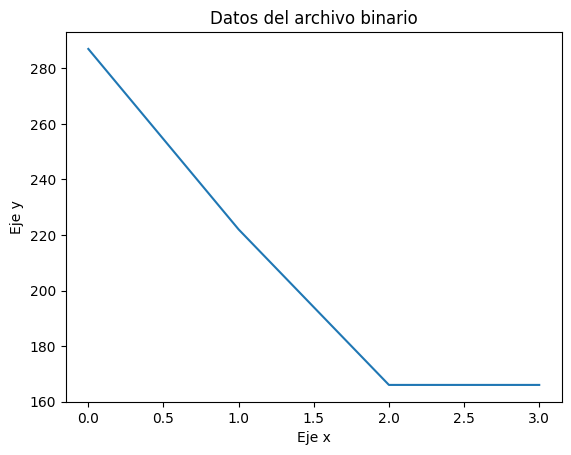

Digite la cedula de la persona que quiere imprimirse: 2023074542


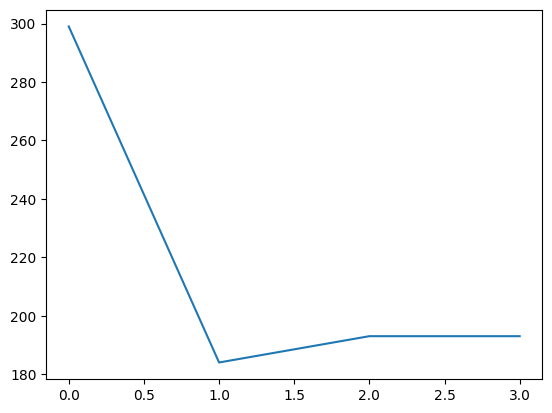

In [ ]:
#Consulta 7
import pickle
import matplotlib.pyplot as plt

# Ruta al archivo binario
x = str(input("Digite la cedula de la persona que quiere imprimirse: "))
ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'

# Abrir el archivo en modo de lectura binaria
with open(ruta_archivo, 'rb') as f:
    # Cargar el primer elemento del archivo utilizando pickle
    primer_elemento = pickle.load(f)

    # Extraer la sublista que se desea graficar
    datos = primer_elemento[0]

    # Crear una lista para las etiquetas del eje x
    etiquetas_x = range(len(datos))

    # Crear la figura y el gráfico
    fig, ax = plt.subplots()

    # Trazar los datos
    ax.plot(etiquetas_x, datos)

    # Establecer los títulos y etiquetas de los ejes
    ax.set_title('Datos del archivo binario')
    ax.set_xlabel('Eje x')
    ax.set_ylabel('Eje y')

    # Mostrar el gráfico
    plt.show()
import matplotlib.pyplot as plt
import pickle

x = str(input("Digite la cedula de la persona que quiere imprimirse: "))
ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'

# Abrir el archivo en modo de lectura binaria
with open(ruta_archivo, 'rb') as f:
    # Cargar el contenido del archivo utilizando pickle
    contenido = pickle.load(f)

# Extraer la sublista del primer elemento
sublista = contenido[0]

# Agregar 6 a cada elemento de la sublista
sublista_con_6_digitos = [x + 6 for x in sublista]

# Graficar los datos de la sublista modificada
plt.plot(sublista_con_6_digitos)
plt.show()


###Cargar las jpg al .bin (NO USAR ELEMENTO FALLIDO)

In [ ]:
"""Este NO
"""
dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + p_entrevistada + '/'
dir_bin = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/'
archivo_bin = p_entrevistada + '.bin'
ruta_bin = os.path.join(dir_bin, archivo_bin)

imagenes = []

# Iterar sobre los archivos JPG en el directorio
for archivo_jpg in os.listdir(dir_jpg):
    if archivo_jpg.endswith('.jpg'):
        # Cargar la imagen y añadirla a la lista
        imagen = Image.open(os.path.join(dir_jpg, archivo_jpg))
        imagenes.append(imagen)

# Abrir el archivo BIN en modo 'ab' (append binary)
with open(ruta_bin, 'ab') as f:
    # Añadir las imágenes a la final del archivo
    pickle.dump(imagenes, f)

In [ ]:
dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + p_entrevistada + '/'
dir_bin = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/'
archivo_bin = p_entrevistada + '.bin'
ruta_bin = os.path.join(dir_bin, archivo_bin)

# Abrir el archivo BIN en modo 'ab' (append binary)
with open(ruta_bin, 'ab') as f:
    # Iterar sobre los archivos JPG en el directorio
    i = 5
    while os.path.exists(os.path.join(dir_jpg, f'{i}.jpg')):
        # Leer el archivo JPG en modo binario y escribirlo directamente en el archivo BIN
        with open(os.path.join(dir_jpg, f'{i}.jpg'), 'rb') as f_jpg:
            f.write(f_jpg.read())
        i += 5

In [ ]:
omg = str(input("Digite la cedula: "))
ruta_bin = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + omg + '.bin'
#lista_archivos = os.listdir(ruta_carpeta)
ruta_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + omg + '/'
imagenes = [archivo for archivo in ruta_jpg if archivo.endswith('.jpg')]

with open(ruta_bin, 'rb') as f:
    data = []
    while True:
        try:
            obj = pickle.load(f)
            data.append(obj)
        except EOFError:
            break

with open(ruta_bin, 'wb') as f:
    for i, d in enumerate(data):
        if i % 2 == 0 and i != 0:
            # Insertar una imagen cada 2 líneas a partir de la línea 1
            omg = ruta_jpg + imagenes.pop(0)
            pickle.dump(omg, f)
        pickle.dump(d, f)
    # Si quedan imágenes por agregar al final
    while imagenes:
        omg = ruta_carpeta + imagenes.pop(0)
        pickle.dump(omg, f)

###Códigos de respaldo (versiones anteriores guardadas por si acaso)

In [ ]:
x = str(input("Digite la cedula de la persona que quiere imprimirse: "))
ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'
dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '/'

# Abrir el archivo en modo de lectura binaria
with open(ruta_archivo, 'rb') as f:
    # Iterar sobre los elementos del archivo
    i = 0
    while True:
        try:
            # Cargar el siguiente elemento del archivo utilizando pickle
            elemento = pickle.load(f)
            # Imprimir el elemento como una cadena de texto
            print(elemento)
            i += 1
            if i % 2 == 0:
                # Imprimir una imagen cada dos líneas
                for filename in os.listdir(dir_jpg):
                    if filename.endswith('.jpg'):
                        # Abrir la imagen y mostrarla
                        img_path = os.path.join(dir_jpg, filename)
                        with Image.open(img_path) as img:
                            img.show()
        except EOFError:
            # Se alcanzó el final del archivo
            break

Díjeite la cedula de la persona que quiere imprimirse: 37
[[226 150 267 267]]
Predicciones: {'angry': 0.01524224, 'disgust': 0.00014081821, 'fear': 0.0106508015, 'happiness': 0.19824459, 'sadness': 0.032921568, 'surprise': 0.0038515283, 'neutral': 0.73894846}
[[228 144 282 282]]
Predicciones: {'angry': 0.025061026, 'disgust': 0.00024151213, 'fear': 0.014696535, 'happiness': 0.14492175, 'sadness': 0.04017198, 'surprise': 0.0057736277, 'neutral': 0.7691335}


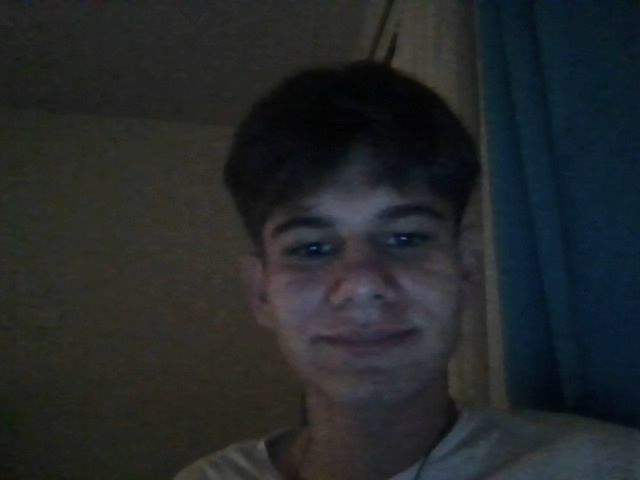

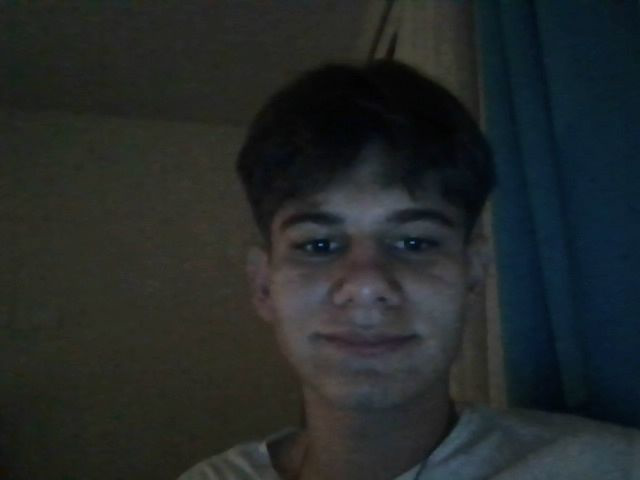

In [ ]:
x = str(input("Díjeite la cedula de la persona que quiere imprimirse: "))
ruta_archivo = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '.bin'
dir_jpg = '/content/drive/MyDrive/Proyecto Taller Progra Jan y Luis/Pruebitas/' + x + '/'

# Abrir el archivo en modo de lectura binaria
with open(ruta_archivo, 'rb') as f:
    # Iterar sobre los elementos del archivo
    while True:
        try:
            # Cargar el siguiente elemento del archivo utilizando pickle
            elemento = pickle.load(f)
            # Imprimir el elemento como una cadena de texto
            print(elemento)
        except EOFError:
            # Se alcanzó el final del archivo
            break
for filename in os.listdir(dir_jpg):
    if filename.endswith('.jpg'):
        # Abrir la imagen y mostrarla
        img_path = os.path.join(dir_jpg, filename)
        with Image.open(img_path) as img:
            img.show()

##Contrataciones

# Consultas


1.   Mostrar la información de todas las personas entrevistas (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

2.   Mostrar la información de todas las personas entrevistas ordenada ascendentemente por edad. El método de ordenamiento a utilizar es el método por inserción (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

3.   Mostrar la información de todas las personas entrevistas ordenada descendente mente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la bubuja (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros.

4. Mostrar la información de todas las personas entrevistas ordenada descendentemente por la cantidad de hijos. El método de ordenamiento a utilizar es el método por de la quicksort (la información debe ser mostrada siendo saca de los diccionarios o listas, no se debe hacer simplemente la impresión en pantalla de los diccionarios o las listas). Además, de mostrar toda la información recolectada de la persona, se debe mostrar todas las imágenes que se recolectaron durante las entrevistas, las emociones reconocidas para cada imagen y las coordenadas donde se encuentra los rostros. También, imprimir una lista con sublistas donde la primera sublista tiene la información de las personas que tienen únicamente hijos de género femenino, la segunda sublista tiene información de personas que tienen únicamente hijos de género masculino y la última sublista tiene información de personas que tienen hijos tanto de género femenino como másculino. 

5. Obtener para cada persona entrevistada las emociones sin ordenar y guardar en una lista (una lista por entrevista) con sublistas la siguiente información: en la primera sublista colocar la identificación, el nombre, el género y la edad de la persona entrevistada, en las siguientes sublistas colocar las emociones expresadas por la persona. Por ejemplo, si la persona apareció en 10 fotogramas entonces se deben crear 10 sublistas, cada sublista pertenece a las emociones emitidas por el candidato en un fotograma. 

6. Una vez creada esta listas (una por entrevista) con sublistas del punto anterior, se debe ordenar las sublistas de forma ascendente por la emoción felicidad (happiness) utilizando el técnica de ordenamiento Quicksort.

7. Para cada persona entrevistada muestre un gráfico para comparar las emociones reportadas durante la entrevista.

8. Incluya en el documento escrito la entrevista a dos personas. De aportar toda la información recolectada, las imágenes recolectadas en la entrevista con un cuadro en los rostros presentes. Además, debe mostrar la información de las emociones reportadas. Por último, incluya un análisis de la importancia de este tipo de algoritmos y de la importancia de la privacidad de la información en este tipo de sistemas.

9. Hacer una nueva entrevista a una persona. Una persona existente (previamente almacena en los archivos) puede volver a ser entrevistada. Debe guardar la nueva entrevista en el mismo archivo agregando la información de esta nueva entrevista a la lista de entrevistas de dicha persona. Tome en cuenta que el entrevistador puede ser uno que no le ha realizado ninguna entrevista.

10. Agregar una evaluación para indicar si la persona será contratada. Una vez que una persona ha sido entrevistada un evaluador puede revisar toda la información y decir si la persona será contratada (Debe mostrar la información de la persona para que el evaluador la revise y debe aportar una propiedad para la persona que se indica llamada "estado" (el estado puede ser entrevistado, contratado y no contratado). Tome en cuenta que el evaluador puede cambiar el estado de la persona para indicar que está contratado o no contratado.


## Aspectos administrativos


* La tarea será desarrollada en equipos de trabajo de máximo 2 personas.
* Cualquier acción de plagio será sancionada con una nota de 0 y la carta al expediente respectiva para todos los
implicados.
* La fecha de entrega será la semana 11, el día de clases, antes de la hora de clases.
* Para llevar el control de versiones del proyecto se debe crear un repositorio en GitLab y agregar al profesor (agregarlo
a la cuenta amendez.tec@gmail.com).
* Para llevar el control del las tareas a realizar por participante en el proyecto debe utilizar la herramienta
https://trello.com/es y compartir el link en el mismo Google Doc en que se comparte el link de la plantilla de Overleaf. Pueden crear tab de todas las tareas o requerimientos, un tab para las tareas en proceso y un tab para las tareas hechas.
* La codificación y documentación interna deberá ser desarrollada en idioma inglés utilizando el estándar docString de Python.
*La documentación externa debe estar redactada en idioma inglés utilizando la herramienta Overleaf (utilizar la plantilla facilitada por el profesor). La documentación es evaluada en el curso de Introducción a la programación.
* Documentación del Código utilizando Docstring Conventions 	
* Introducción a Python la Guía de Estilo de Código en Python
* La entrega será mediante la plataforma TecDigital en el espacio de Proyecto – Etapa 1. Lo que debe subir es un archivo de tipo notebook cuya extensión es (.ipynb). Además, en este archivo deben venir los enlaces a las imagenes utilizados para la tarea.
* Se recomienda que se empiece a trabajar lo antes posible.



# "La programación es una habilidad que puedes cultivar en ti mismo y usar para cambiar el mundo". - Barack Obama